# Import packages

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from scipy import stats
from sklearn import preprocessing, ensemble, metrics, linear_model, model_selection, inspection
import geopandas as gpd
import xarray as xr
import rioxarray as rxr
from shapely import geometry
import cartopy.feature as cfeature
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
# import semopy
import datetime as dt
from scipy import interpolate
from tqdm import tqdm
from pprint import pprint
from scipy.spatial.distance import cdist
from scipy.misc import derivative
from findiff import FinDiff
import glob
import utils
import warnings
warnings.filterwarnings("ignore")
# import pingouin as pg
# import xgboost
# import shap
# shap.initjs()

D:\dev\Anaconda3\envs\pygeo\lib\site-packages\geopandas\_compat.py:124: UserWarning: The Shapely GEOS version (3.10.1-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


# Functions

In [2]:
def extract_sample_values(df_samples, raster, x_name='lon', y_name='lat', method='nearest'):
    extracted_values = []
    xs_sample = xr.DataArray(np.array(df_samples[x_name]), dims='points')
    ys_sample = xr.DataArray(np.array(df_samples[y_name]), dims='points')
    extracted_values = raster.sel(x=xs_sample, y=ys_sample, method=method).data
    extracted_values = np.array(extracted_values).T
    return extracted_values

def merge_covar(df, df_covar, covar_name, on_key='profile_id'):
    df_covar = df_covar[list(df_covar.columns)[:2]]
    df_covar.columns = [on_key, covar_name]
    df_merged = pd.merge(left=df, right=df_covar, on=on_key)
    df_merged = df_merged.reset_index(drop=True)
    return df_merged

def get_soil_property_0to100(df_dir, soil_property_name, only_2_layers=True):
    df_samples_soil_property = pd.read_csv('{}/samples_{}_0-5cm_mean.csv'.format(df_dir, soil_property_name))
    df_samples_soil_property.columns = list(df_samples_soil_property.columns)[:-1] + ['{}_0-5'.format(soil_property_name)]
    df_samples_soil_property = pd.merge(left=df_samples_soil_property, right=pd.read_csv('{}/samples_{}_5-15cm_mean.csv'.format(df_dir, soil_property_name)), on='profile_id')
    df_samples_soil_property.columns = list(df_samples_soil_property.columns)[:-1] + ['{}_5-15'.format(soil_property_name)]
    df_samples_soil_property = pd.merge(left=df_samples_soil_property, right=pd.read_csv('{}/samples_{}_15-30cm_mean.csv'.format(df_dir, soil_property_name)), on='profile_id')
    df_samples_soil_property.columns = list(df_samples_soil_property.columns)[:-1] + ['{}_15-30'.format(soil_property_name)]
    df_samples_soil_property = pd.merge(left=df_samples_soil_property, right=pd.read_csv('{}/samples_{}_30-60cm_mean.csv'.format(df_dir, soil_property_name)), on='profile_id')
    df_samples_soil_property.columns = list(df_samples_soil_property.columns)[:-1] + ['{}_30-60'.format(soil_property_name)]
    df_samples_soil_property = pd.merge(left=df_samples_soil_property, right=pd.read_csv('{}/samples_{}_60-100cm_mean.csv'.format(df_dir, soil_property_name)), on='profile_id')
    df_samples_soil_property.columns = list(df_samples_soil_property.columns)[:-1] + ['{}_60-100'.format(soil_property_name)]

    df_samples_soil_property['{}_pred_0to30'.format(soil_property_name)] = (df_samples_soil_property['{}_0-5'.format(soil_property_name)] * 5 + df_samples_soil_property['{}_5-15'.format(soil_property_name)] * 10 + df_samples_soil_property['{}_15-30'.format(soil_property_name)] * 15) / 30.0
    df_samples_soil_property['{}_pred_30to100'.format(soil_property_name)] = (df_samples_soil_property['{}_30-60'.format(soil_property_name)] * 30 + df_samples_soil_property['{}_60-100'.format(soil_property_name)] * 40) / 60.0
    if only_2_layers:
        df_samples_soil_property = df_samples_soil_property[['profile_id', '{}_pred_0to30'.format(soil_property_name), '{}_pred_30to100'.format(soil_property_name)]]
    return df_samples_soil_property

def get_soil_property_0to30(df_dir, soil_property_name):
    df_samples_soil_property = pd.read_csv('{}/samples_{}_0-30cm_mean.csv'.format(df_dir, soil_property_name))
    df_samples_soil_property.columns = list(df_samples_soil_property.columns)[:-1] + ['{}_0-30'.format(soil_property_name)]

    df_samples_soil_property['{}_pred_0to30'.format(soil_property_name)] = df_samples_soil_property['{}_0-30'.format(soil_property_name)]
    df_samples_soil_property = df_samples_soil_property[['profile_id', '{}_pred_0to30'.format(soil_property_name)]]
    return df_samples_soil_property

def get_nearest_idx(df, lat_name, lon_name, lat, lon):
    loc_df = np.array(df[[lat_name, lon_name]])
    loc_pnt = np.array([[lat, lon]])
    dist = cdist(loc_df, loc_pnt, metric='euclidean')[:, 0]
    nearest_idx = np.argmin(dist)
    dist_min = np.min(dist)
    return nearest_idx, dist_min

def Q01(x):
    return x.quantile(0.01)

def Q025(x):
    return x.quantile(0.025)
    
def Q05(x):
    return x.quantile(0.05)

def Q10(x):
    return x.quantile(0.10)
    
def Q50(x):
    return x.quantile(0.50)

def Q90(x):
    return x.quantile(0.90)
    
def Q95(x):
    return x.quantile(0.95)

def Q975(x):
    return x.quantile(0.975)

def Q99(x):
    return x.quantile(0.99)

# Load data

## All sample locations

In [3]:
df_loc_all = pd.read_csv('./data/samples/df_profile_loc_wosis_lucas_ncscd_tropsoc_chinasoil.csv')
print(df_loc_all.shape)

(247018, 3)


## Load processed sample data with SOCS

In [4]:
df_top = pd.read_csv('./data/samples/df_socs_0to30_v4.csv')
df_sub = pd.read_csv('./data/samples/df_socs_30to100_v4.csv')

print(df_top.shape)
print(df_sub.shape)

(104097, 4)
(72197, 4)


In [ ]:
top_or_sub = 'topsoil'

In [5]:
top_or_sub = 'subsoil'

In [6]:
if top_or_sub == 'topsoil':
    df = df_top
else:
    df = df_sub

In [7]:
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['longitude'], df['latitude']), crs=4326)
print(gdf.shape)
gdf.head(2)

(72197, 5)


,profile_id,latitude,longitude,socs,geometry
0,36897,50.649889,4.666901,0.347342,POINT (4.66690 50.64989)
1,36898,50.583962,4.462114,0.392287,POINT (4.46211 50.58396)


## Merge sample data with country data (developing or develped countries)

In [8]:
gdf_gadm = gpd.read_file(filename='Z:/data_hub/world_shp/gadm36.shp')

print(gdf_gadm.shape)
gdf_gadm.head(2)

(339127, 60)


,UID,GID_0,ID_0,NAME_0,GID_1,ID_1,NAME_1,VARNAME_1,NL_NAME_1,HASC_1,...,GID_5,ID_5,NAME_5,CC_5,TYPE_5,ENGTYPE_5,REGION,VARREGION,zone,geometry
0,183022,AFG,1.0,Afghanistan,AFG.1_1,1.0,Badakhshan,Badahšan,None,AF.BD,...,None,NaN,None,None,None,None,None,None,4,"POLYGON ((71.18169 36.49196, 71.18560 36.49435..."
1,182550,AFG,1.0,Afghanistan,AFG.1_1,1.0,Badakhshan,Badahšan,None,AF.BD,...,None,NaN,None,None,None,None,None,None,4,"POLYGON ((71.33762 38.11841, 71.33733 38.11514..."


In [9]:
gdf = gpd.sjoin(left_df=gdf, right_df=gdf_gadm[['UID', 'GID_0', 'NAME_0', 'GID_1', 'NAME_1', 'GID_2', 'NAME_2', 'GID_3', 'NAME_3', 'GID_4', 'NAME_4', 'geometry']], how='left', op='intersects')
gdf = gdf.drop('index_right', axis=1)

print(gdf.shape)
print(list(gdf.columns))
gdf.head(2)

(72197, 16)
['profile_id', 'latitude', 'longitude', 'socs', 'geometry', 'UID', 'GID_0', 'NAME_0', 'GID_1', 'NAME_1', 'GID_2', 'NAME_2', 'GID_3', 'NAME_3', 'GID_4', 'NAME_4']


,profile_id,latitude,longitude,socs,geometry,UID,GID_0,NAME_0,GID_1,NAME_1,GID_2,NAME_2,GID_3,NAME_3,GID_4,NAME_4
0,36897,50.649889,4.666901,0.347342,POINT (4.66690 50.64989),46721.0,BEL,Belgium,BEL.3_1,Wallonie,BEL.3.1_1,Brabant Wallon,BEL.3.1.1_1,Nivelles,BEL.3.1.1.15_1,Mont-Saint-Guibert
1,36898,50.583962,4.462114,0.392287,POINT (4.46211 50.58396),46742.0,BEL,Belgium,BEL.3_1,Wallonie,BEL.3.1_1,Brabant Wallon,BEL.3.1.1_1,Nivelles,BEL.3.1.1.7_1,Genappe


In [10]:
df_country_income_level = pd.read_csv('./data/country/country_income_level.csv')

df_country_income_level['IncomeGroup'] = df_country_income_level['IncomeGroup'].astype('str')
df_country_income_level['IncomeGroup'] = df_country_income_level['IncomeGroup'].where(df_country_income_level['IncomeGroup'] != 'nan', 'NA')
print(list(np.unique(df_country_income_level['IncomeGroup'])))

print(df_country_income_level.shape)
df_country_income_level.head(2)

['High income', 'Low income', 'Lower middle income', 'NA', 'Upper middle income']
(265, 6)


,Country Code,Region,IncomeGroup,SpecialNotes,TableName,Unnamed: 5
0,ABW,Latin America & Caribbean,High income,NaN,Aruba,NaN
1,AFE,NaN,NA,"26 countries, stretching from the Red Sea in t...",Africa Eastern and Southern,NaN


In [11]:
gdf = pd.merge(left=gdf, right=df_country_income_level[['Country Code', 'IncomeGroup']], left_on='GID_0', right_on='Country Code', how='left').drop('Country Code', axis=1)

gdf['IncomeGroup'] = gdf['IncomeGroup'].astype('str')
gdf['IncomeGroup'] = gdf['IncomeGroup'].where(gdf['IncomeGroup'] != 'nan', 'NA')
print(list(np.unique(gdf['IncomeGroup'])))

['High income', 'Low income', 'Lower middle income', 'NA', 'Upper middle income']


## Merge sample data with biomes

### Ecoregion data

In [12]:
dir_cov_data = './data/covariates/cov_data_2024/covs/'

In [13]:
LC_MODIS_dict = {
    1:  'Evergreen Needleleaf Forests',
    2:  'Evergreen Broadleaf Forests',
    3:  'Deciduous Needleleaf Forests',
    4:  'Deciduous Broadleaf Forests',
    5:  'Mixed Forests',
    6:  'Closed Shrublands',
    7:  'Open Shrublands',
    8:  'Woody Savannas',
    9:  'Savannas',
    10: 'Grasslands',
    11: 'Permanent Wetlands',
    12: 'Croplands',
    13: 'Urban and Built-up Lands',
    14: 'Cropland/Natural Vegetation Mosaics',
    15: 'Permanent Snow and Ice',
    16: 'Barren',
    17: 'Water Bodies',
}

In [14]:
df_covar = pd.read_csv('{}/samples_biome.csv'.format(dir_cov_data))
gdf = merge_covar(df=gdf, df_covar=df_covar, covar_name='biome', on_key='profile_id')
# df_covar.groupby(['mean']).agg('count')
gdf = gdf.rename(columns={'biome': 'biome_OpenLandMap'})

df_covar = pd.read_csv('{}/samples_landcover.csv'.format(dir_cov_data))
gdf = merge_covar(df=gdf, df_covar=df_covar, covar_name='lc_id_modis', on_key='profile_id')
print(len(list(np.unique(gdf['lc_id_modis']))), list(np.unique(gdf['lc_id_modis'])))

gdf['lc_name_modis'] = [LC_MODIS_dict[lc_id] for lc_id in gdf['lc_id_modis']]

print(gdf.shape)
print(list(gdf.columns))
gdf.head()

17 [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0]
(72156, 20)
['profile_id', 'latitude', 'longitude', 'socs', 'geometry', 'UID', 'GID_0', 'NAME_0', 'GID_1', 'NAME_1', 'GID_2', 'NAME_2', 'GID_3', 'NAME_3', 'GID_4', 'NAME_4', 'IncomeGroup', 'biome_OpenLandMap', 'lc_id_modis', 'lc_name_modis']


,profile_id,latitude,longitude,socs,geometry,UID,GID_0,NAME_0,GID_1,NAME_1,GID_2,NAME_2,GID_3,NAME_3,GID_4,NAME_4,IncomeGroup,biome_OpenLandMap,lc_id_modis,lc_name_modis
0,36897,50.649889,4.666901,0.347342,POINT (4.66690 50.64989),46721.0,BEL,Belgium,BEL.3_1,Wallonie,BEL.3.1_1,Brabant Wallon,BEL.3.1.1_1,Nivelles,BEL.3.1.1.15_1,Mont-Saint-Guibert,High income,13.0,12.0,Croplands
1,36898,50.583962,4.462114,0.392287,POINT (4.46211 50.58396),46742.0,BEL,Belgium,BEL.3_1,Wallonie,BEL.3.1_1,Brabant Wallon,BEL.3.1.1_1,Nivelles,BEL.3.1.1.7_1,Genappe,High income,13.0,12.0,Croplands
2,36899,50.597876,4.687607,0.561489,POINT (4.68761 50.59788),46752.0,BEL,Belgium,BEL.3_1,Wallonie,BEL.3.1_1,Brabant Wallon,BEL.3.1.1_1,Nivelles,BEL.3.1.1.25_1,Walhain,High income,13.0,12.0,Croplands
3,36900,50.633599,4.681783,0.592344,POINT (4.68178 50.63360),46752.0,BEL,Belgium,BEL.3_1,Wallonie,BEL.3.1_1,Brabant Wallon,BEL.3.1.1_1,Nivelles,BEL.3.1.1.25_1,Walhain,High income,13.0,12.0,Croplands
4,36901,50.623204,4.466035,0.641663,POINT (4.46603 50.62320),46742.0,BEL,Belgium,BEL.3_1,Wallonie,BEL.3.1_1,Brabant Wallon,BEL.3.1.1_1,Nivelles,BEL.3.1.1.7_1,Genappe,High income,13.0,12.0,Croplands


In [15]:
gdf_ecoregion = gpd.read_file(filename='./data/Ecoregions2017/Ecoregions2017.shp')

print(gdf_ecoregion.shape)
gdf_ecoregion.head(2)

(847, 16)


,OBJECTID,ECO_NAME,BIOME_NUM,BIOME_NAME,REALM,ECO_BIOME_,NNH,ECO_ID,SHAPE_LENG,SHAPE_AREA,NNH_NAME,COLOR,COLOR_BIO,COLOR_NNH,LICENSE,geometry
0,1.0,Adelie Land tundra,11.0,Tundra,Antarctica,AN11,1,117,9.749780,0.038948,Half Protected,#63CFAB,#9ED7C2,#257339,CC-BY 4.0,"MULTIPOLYGON (((158.71410 -69.60657, 158.71264..."
1,2.0,Admiralty Islands lowland rain forests,1.0,Tropical & Subtropical Moist Broadleaf Forests,Australasia,AU01,2,135,4.800349,0.170599,Nature Could Reach Half Protected,#70A800,#38A700,#7BC141,CC-BY 4.0,"MULTIPOLYGON (((147.28819 -2.57589, 147.27150 ..."


In [16]:
# gdf_ecoregion_wwf = gpd.read_file(filename='./data/TerrestrialEcos/wwf_terr_ecos.shp')

# colname_list_wwf = ['wwf_{}'.format(colname) for colname in list(gdf_ecoregion_wwf.columns)]
# gdf_ecoregion_wwf.columns = colname_list_wwf

# print(gdf_ecoregion_wwf.shape)
# gdf_ecoregion_wwf.head(2)

In [17]:
gdf = gpd.sjoin(left_df=gdf, right_df=gdf_ecoregion, how='inner', op='intersects').drop('LICENSE', axis=1)
gdf = gdf.drop('index_right', axis=1)

print(gdf.shape)
print(list(gdf.columns))
gdf.head(2)

(71868, 34)
['profile_id', 'latitude', 'longitude', 'socs', 'geometry', 'UID', 'GID_0', 'NAME_0', 'GID_1', 'NAME_1', 'GID_2', 'NAME_2', 'GID_3', 'NAME_3', 'GID_4', 'NAME_4', 'IncomeGroup', 'biome_OpenLandMap', 'lc_id_modis', 'lc_name_modis', 'OBJECTID', 'ECO_NAME', 'BIOME_NUM', 'BIOME_NAME', 'REALM', 'ECO_BIOME_', 'NNH', 'ECO_ID', 'SHAPE_LENG', 'SHAPE_AREA', 'NNH_NAME', 'COLOR', 'COLOR_BIO', 'COLOR_NNH']


,profile_id,latitude,longitude,socs,geometry,UID,GID_0,NAME_0,GID_1,NAME_1,...,REALM,ECO_BIOME_,NNH,ECO_ID,SHAPE_LENG,SHAPE_AREA,NNH_NAME,COLOR,COLOR_BIO,COLOR_NNH
0,36897,50.649889,4.666901,0.347342,POINT (4.66690 50.64989),46721.0,BEL,Belgium,BEL.3_1,Wallonie,...,Palearctic,PA04,3,664,134.960163,48.383344,Nature Could Recover,#67BA48,#00734C,#F9A91B
1,36898,50.583962,4.462114,0.392287,POINT (4.46211 50.58396),46742.0,BEL,Belgium,BEL.3_1,Wallonie,...,Palearctic,PA04,3,664,134.960163,48.383344,Nature Could Recover,#67BA48,#00734C,#F9A91B


In [18]:
# gdf_soiltype = gpd.read_file('./data/soil_classes/soil_types.shp')
# gdf_soiltype = gdf_soiltype.set_crs(crs='EPSG:4326')

# print(gdf_soiltype.shape)
# gdf_soiltype.head(2)

# gdf = gpd.sjoin(left_df=gdf, right_df=gdf_soiltype, how='inner', op='intersects')
# gdf = gdf.drop('index_right', axis=1)

# print(gdf.shape)
# print(list(gdf.columns))
# gdf.head(2)

In [19]:
gdf = gdf[gdf['BIOME_NAME'] != 'N/A'].reset_index(drop=True)

print(gdf.shape)
print(list(gdf.columns))
gdf.head(2)

(71863, 34)
['profile_id', 'latitude', 'longitude', 'socs', 'geometry', 'UID', 'GID_0', 'NAME_0', 'GID_1', 'NAME_1', 'GID_2', 'NAME_2', 'GID_3', 'NAME_3', 'GID_4', 'NAME_4', 'IncomeGroup', 'biome_OpenLandMap', 'lc_id_modis', 'lc_name_modis', 'OBJECTID', 'ECO_NAME', 'BIOME_NUM', 'BIOME_NAME', 'REALM', 'ECO_BIOME_', 'NNH', 'ECO_ID', 'SHAPE_LENG', 'SHAPE_AREA', 'NNH_NAME', 'COLOR', 'COLOR_BIO', 'COLOR_NNH']


,profile_id,latitude,longitude,socs,geometry,UID,GID_0,NAME_0,GID_1,NAME_1,...,REALM,ECO_BIOME_,NNH,ECO_ID,SHAPE_LENG,SHAPE_AREA,NNH_NAME,COLOR,COLOR_BIO,COLOR_NNH
0,36897,50.649889,4.666901,0.347342,POINT (4.66690 50.64989),46721.0,BEL,Belgium,BEL.3_1,Wallonie,...,Palearctic,PA04,3,664,134.960163,48.383344,Nature Could Recover,#67BA48,#00734C,#F9A91B
1,36898,50.583962,4.462114,0.392287,POINT (4.46211 50.58396),46742.0,BEL,Belgium,BEL.3_1,Wallonie,...,Palearctic,PA04,3,664,134.960163,48.383344,Nature Could Recover,#67BA48,#00734C,#F9A91B


In [20]:
gdf.groupby(['BIOME_NUM', 'BIOME_NAME']).agg({'profile_id': 'count'})

,,profile_id
BIOME_NUM,BIOME_NAME,
1.0,Tropical & Subtropical Moist Broadleaf Forests,5812
2.0,Tropical & Subtropical Dry Broadleaf Forests,1681
3.0,Tropical & Subtropical Coniferous Forests,382
4.0,Temperate Broadleaf & Mixed Forests,21088
5.0,Temperate Conifer Forests,4602
6.0,Boreal Forests/Taiga,2399
7.0,"Tropical & Subtropical Grasslands, Savannas & Shrublands",10799
8.0,"Temperate Grasslands, Savannas & Shrublands",14703
9.0,Flooded Grasslands & Savannas,394


### Merge sample data with permafrost extent data

In [22]:
gdf_permafrost_extent = gpd.read_file(filename='./data/permafrost/Circum-Arctic Map of Permafrost and Ground-Ice Conditions/ggd318_map_circumarctic/permafrost_area_wgs84.shp')
gdf_permafrost_extent = gdf_permafrost_extent.to_crs(epsg=4326)
gdf_permafrost_extent.columns = ['permafrost_CODE', 'permafrost_COMBO', 'permafrost_RELICT', 'permafrost_EXTENT', 'permafrost_CONTENT', 'permafrost_LANDFORM', 'geometry']
print(gdf_permafrost_extent.shape)
gdf_permafrost_extent.head(2)

(7191, 7)


,permafrost_CODE,permafrost_COMBO,permafrost_RELICT,permafrost_EXTENT,permafrost_CONTENT,permafrost_LANDFORM,geometry
0,20,Ilr,None,I,l,r,"POLYGON ((1.72921 41.70716, 1.68562 41.71751, ..."
1,20,Ilr,None,I,l,r,"POLYGON ((2.46273 42.35951, 2.47144 42.34507, ..."


<Axes: >

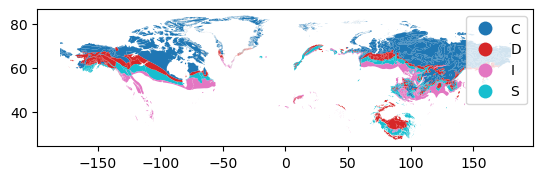

In [23]:
gdf_permafrost_extent.plot(column="permafrost_EXTENT", legend=True)

In [24]:
gdf = gpd.sjoin(left_df=gdf, right_df=gdf_permafrost_extent, how='left', op='intersects')
# gdf = gpd.sjoin_nearest(left_df=gdf, right_df=gdf_permafrost_extent, how='left', max_distance=1, distance_col=None)
gdf = gdf.drop('index_right', axis=1)

print(gdf.shape)
print(list(gdf.columns))
gdf.head(2)

(71863, 40)
['profile_id', 'latitude', 'longitude', 'socs', 'geometry', 'UID', 'GID_0', 'NAME_0', 'GID_1', 'NAME_1', 'GID_2', 'NAME_2', 'GID_3', 'NAME_3', 'GID_4', 'NAME_4', 'IncomeGroup', 'biome_OpenLandMap', 'lc_id_modis', 'lc_name_modis', 'OBJECTID', 'ECO_NAME', 'BIOME_NUM', 'BIOME_NAME', 'REALM', 'ECO_BIOME_', 'NNH', 'ECO_ID', 'SHAPE_LENG', 'SHAPE_AREA', 'NNH_NAME', 'COLOR', 'COLOR_BIO', 'COLOR_NNH', 'permafrost_CODE', 'permafrost_COMBO', 'permafrost_RELICT', 'permafrost_EXTENT', 'permafrost_CONTENT', 'permafrost_LANDFORM']


,profile_id,latitude,longitude,socs,geometry,UID,GID_0,NAME_0,GID_1,NAME_1,...,NNH_NAME,COLOR,COLOR_BIO,COLOR_NNH,permafrost_CODE,permafrost_COMBO,permafrost_RELICT,permafrost_EXTENT,permafrost_CONTENT,permafrost_LANDFORM
0,36897,50.649889,4.666901,0.347342,POINT (4.66690 50.64989),46721.0,BEL,Belgium,BEL.3_1,Wallonie,...,Nature Could Recover,#67BA48,#00734C,#F9A91B,NaN,NaN,NaN,NaN,NaN,NaN
1,36898,50.583962,4.462114,0.392287,POINT (4.46211 50.58396),46742.0,BEL,Belgium,BEL.3_1,Wallonie,...,Nature Could Recover,#67BA48,#00734C,#F9A91B,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
gdf['permafrost_CODE'] = gdf['permafrost_CODE'].astype('str')
gdf['permafrost_CODE'] = gdf['permafrost_CODE'].where(gdf['permafrost_CODE'] != 'None', 'NA')
gdf['permafrost_CODE'] = gdf['permafrost_CODE'].where(gdf['permafrost_CODE'] != 'nan', 'NA')

gdf['permafrost_COMBO'] = gdf['permafrost_COMBO'].astype('str')
gdf['permafrost_COMBO'] = gdf['permafrost_COMBO'].where(gdf['permafrost_COMBO'] != 'None', 'NA')
gdf['permafrost_COMBO'] = gdf['permafrost_COMBO'].where(gdf['permafrost_COMBO'] != 'nan', 'NA')

gdf['permafrost_RELICT'] = gdf['permafrost_RELICT'].astype('str')
gdf['permafrost_RELICT'] = gdf['permafrost_RELICT'].where(gdf['permafrost_RELICT'] != 'None', 'NA')
gdf['permafrost_RELICT'] = gdf['permafrost_RELICT'].where(gdf['permafrost_RELICT'] != 'nan', 'NA')

gdf['permafrost_EXTENT'] = gdf['permafrost_EXTENT'].astype('str')
gdf['permafrost_EXTENT'] = gdf['permafrost_EXTENT'].where(gdf['permafrost_EXTENT'] != 'None', 'NA')
gdf['permafrost_EXTENT'] = gdf['permafrost_EXTENT'].where(gdf['permafrost_EXTENT'] != 'nan', 'NA')


gdf['permafrost_CONTENT'] = gdf['permafrost_CONTENT'].astype('str')
gdf['permafrost_CONTENT'] = gdf['permafrost_CONTENT'].where(gdf['permafrost_CONTENT'] != 'None', 'NA')
gdf['permafrost_CONTENT'] = gdf['permafrost_CONTENT'].where(gdf['permafrost_CONTENT'] != 'nan', 'NA')

gdf['permafrost_LANDFORM'] = gdf['permafrost_LANDFORM'].astype('str')
gdf['permafrost_LANDFORM'] = gdf['permafrost_LANDFORM'].where(gdf['permafrost_LANDFORM'] != 'None', 'NA')
gdf['permafrost_LANDFORM'] = gdf['permafrost_LANDFORM'].where(gdf['permafrost_LANDFORM'] != 'nan', 'NA')

# permafrost_EXTENT_list = []
# for i in range(len(gdf)):
#     permafrost_EXTENT = gdf['permafrost_EXTENT'][i]
#     if permafrost_EXTENT == 'NA':
#         if gdf['BIOME_NAME'][i] == 'Tundra':
#             permafrost_EXTENT = 'C'
#     permafrost_EXTENT_list.append(permafrost_EXTENT)
# gdf['permafrost_EXTENT'] = permafrost_EXTENT_list

is_permafrost_list = []
for i in range(len(gdf)):
    is_permafrost = 'Non-permafrost'
    if gdf['permafrost_EXTENT'][i] not in ['NA'] or gdf['BIOME_NAME'][i] in ['Tundra'] or gdf['lc_name_modis'][i] in ['Permanent Snow and Ice']:
        is_permafrost = 'Permafrost'
    else:
        is_permafrost = 'Non-permafrost'
    is_permafrost_list.append(is_permafrost)
gdf['is_permafrost'] = is_permafrost_list

print(list(np.unique(gdf['permafrost_CODE'])))
print(list(np.unique(gdf['permafrost_EXTENT'])))
print(list(np.unique(gdf['is_permafrost'])))

['1', '10', '11', '12', '13', '14', '15', '17', '18', '19', '2', '20', '3', '4', '5', '6', '7', '8', '9', 'NA']
['C', 'D', 'I', 'NA', 'S']
['Non-permafrost', 'Permafrost']


In [26]:
permafrost_EXTENT_id_list = []
for i in range(len(gdf)):
    permafrost_EXTENT_id = 0
    permafrost_EXTENT = gdf['permafrost_EXTENT'][i]
    if permafrost_EXTENT == 'C':
        permafrost_EXTENT_id = 1
    elif permafrost_EXTENT == 'D':
        permafrost_EXTENT_id = 2
    elif permafrost_EXTENT == 'S':
        permafrost_EXTENT_id = 3
    elif permafrost_EXTENT == 'I':
        permafrost_EXTENT_id = 4
    else:
        permafrost_EXTENT_id = 0
    permafrost_EXTENT_id_list.append(permafrost_EXTENT_id)
gdf['permafrost_EXTENT_id'] = permafrost_EXTENT_id_list

2509


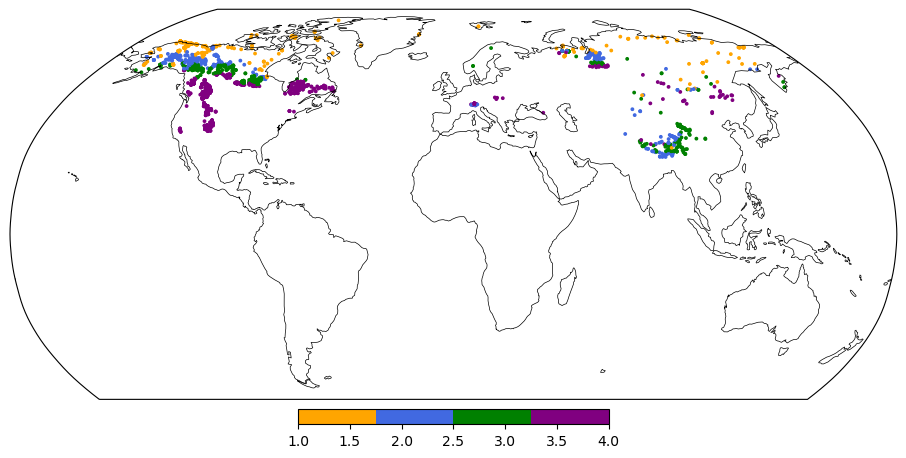

In [29]:
plt.figure(figsize=(10, 5), dpi=100)
# crs = ccrs.PlateCarree(central_longitude=0.0, globe=None)
crs = ccrs.Robinson(central_longitude=0, globe=None)
ax = plt.axes(projection=crs)
ax._autoscaleXon = False
ax._autoscaleYon = False

ax.coastlines(linewidth=0.5)

gdf_ = gdf[gdf['permafrost_EXTENT'] != 'NA'].reset_index(drop=True)
# gdf_ = gdf.copy()
print(len(gdf_))

cmap = mpl.colors.ListedColormap(['orange', 'royalblue', 'green', 'purple'], 'indexed')
plt_points = ax.scatter(gdf_['longitude'], gdf_['latitude'], c=gdf_['permafrost_EXTENT_id'],
                        marker='o', s=3, cmap=cmap,
                        transform=ccrs.PlateCarree())
plt.colorbar(plt_points, cmap=cmap, orientation='horizontal', ticklocation='bottom', spacing='proportional', extend='neither', shrink=0.32, pad=0.02)

extent=[-179.999, 179.999, -60, 90]
ax.set_extent(extent, crs=ccrs.PlateCarree())
plt.tight_layout()

plt.savefig('./figure/sample-level_maps/samples_permaforest_{}.jpg'.format(top_or_sub), bbox_inches='tight', dpi=600)
plt.show()

### Extract cropland (take four main crop types as an example) data

In [30]:
crop_maize = rxr.open_rasterio(filename='./data/cropland/GEOGLAM-BACS_v1.0.0/Percent_Maize.tif')
crop_maize.data = crop_maize.data * 0.0001

crop_soybean = rxr.open_rasterio(filename='./data/cropland/GEOGLAM-BACS_v1.0.0/Percent_Soybean.tif')
crop_soybean.data = crop_soybean.data * 0.0001

crop_wheat_winter = rxr.open_rasterio(filename='./data/cropland/GEOGLAM-BACS_v1.0.0/Percent_Winter_Wheat.tif')
crop_wheat_winter.data = crop_wheat_winter.data * 0.0001

crop_wheat_spring = rxr.open_rasterio(filename='./data/cropland/GEOGLAM-BACS_v1.0.0/Percent_Spring_Wheat.tif')
crop_wheat_spring.data = crop_wheat_spring.data * 0.0001

crop_rice = rxr.open_rasterio(filename='./data/cropland/GEOGLAM-BACS_v1.0.0/Percent_Rice.tif')
crop_rice.data = crop_rice.data * 0.0001

In [31]:
sample_values_maize = extract_sample_values(df_samples=gdf, raster=crop_maize, x_name='longitude', y_name='latitude', method='nearest')
sample_values_soybean = extract_sample_values(df_samples=gdf, raster=crop_soybean, x_name='longitude', y_name='latitude', method='nearest')
sample_values_wheat_winter = extract_sample_values(df_samples=gdf, raster=crop_wheat_winter, x_name='longitude', y_name='latitude', method='nearest')
sample_values_wheat_spring = extract_sample_values(df_samples=gdf, raster=crop_wheat_spring, x_name='longitude', y_name='latitude', method='nearest')
sample_values_rice = extract_sample_values(df_samples=gdf, raster=crop_rice, x_name='longitude', y_name='latitude', method='nearest')

gdf['crop_prop_maize'] = sample_values_maize
gdf['crop_prop_soybean'] = sample_values_soybean
gdf['crop_prop_wheat_winter'] = sample_values_wheat_winter
gdf['crop_prop_wheat_spring'] = sample_values_wheat_spring
gdf['crop_prop_rice'] = sample_values_rice

In [32]:
crop_prop_threshold = 0.1

crop_type_domain_list = []
crop_type_domain_id_list = []
crop_prop_sum_list = []
crop_prop_domain_list = []
for i in tqdm(range(len(gdf))):
    crop_prop_maize = gdf['crop_prop_maize'][i]
    crop_prop_soybean = gdf['crop_prop_soybean'][i]
    crop_prop_wheat_winter = gdf['crop_prop_wheat_winter'][i]
    crop_prop_wheat_spring = gdf['crop_prop_wheat_spring'][i]
    crop_prop_rice = gdf['crop_prop_rice'][i]
    crop_name_list = ['maize', 'soybean', 'wheat_winter', 'wheat_spring', 'rice']
    crop_prop_list = [crop_prop_maize, crop_prop_soybean, crop_prop_wheat_winter, crop_prop_wheat_spring, crop_prop_rice]
    crop_type_domain = crop_name_list[np.argmax(crop_prop_list)]
    crop_type_domain_id = np.argmax(crop_prop_list) + 1
    crop_prop_sum = np.sum(crop_prop_list)
    crop_prop_domain = np.max(crop_prop_list)
    if crop_prop_domain < crop_prop_threshold:
        crop_type_domain = 'nocrop'
        crop_type_domain_id = '0'

    crop_type_domain_list.append(crop_type_domain)
    crop_type_domain_id_list.append(crop_type_domain_id)
    crop_prop_sum_list.append(crop_prop_sum)
    crop_prop_domain_list.append(crop_prop_domain)

gdf['crop_type_domain'] = crop_type_domain_list
gdf['crop_type_domain_id'] = crop_type_domain_id_list
gdf['crop_prop_sum'] = crop_prop_sum_list
gdf['crop_prop_domain'] = crop_prop_domain_list

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 71863/71863 [00:04<00:00, 17548.55it/s]


21351


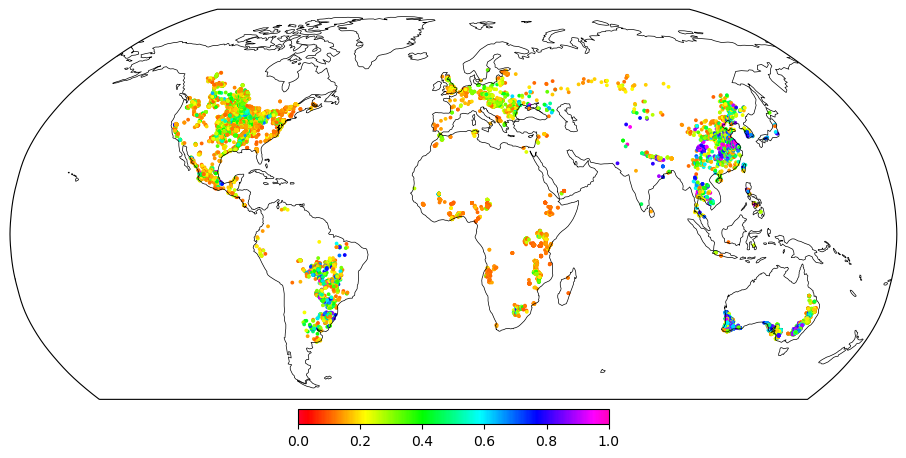

In [34]:
plt.figure(figsize=(10, 5), dpi=100)
# crs = ccrs.PlateCarree(central_longitude=0.0, globe=None)
crs = ccrs.Robinson(central_longitude=0, globe=None)
ax = plt.axes(projection=crs)
ax._autoscaleXon = False
ax._autoscaleYon = False

ax.coastlines(linewidth=0.5)

gdf_ = gdf[gdf['crop_type_domain'] != 'nocrop'].reset_index(drop=True)
print(len(gdf_))

cmap = plt.get_cmap('gist_rainbow')
plt_points = ax.scatter(gdf_['longitude'], gdf_['latitude'], c=gdf_['crop_prop_domain'],
                        marker='o', s=3, cmap=cmap, vmin=0, vmax=1,
                        transform=ccrs.PlateCarree())
plt.colorbar(plt_points, cmap=cmap, orientation='horizontal', ticklocation='auto', spacing='proportional', extend='neither', shrink=0.32, pad=0.02)

extent=[-179.999, 179.999, -60, 90]
ax.set_extent(extent, crs=ccrs.PlateCarree())
plt.tight_layout()

plt.savefig('./figure/sample-level_maps/samples_crop_prop_domain_{}.jpg'.format(top_or_sub), bbox_inches='tight', dpi=600)
plt.show()

21351


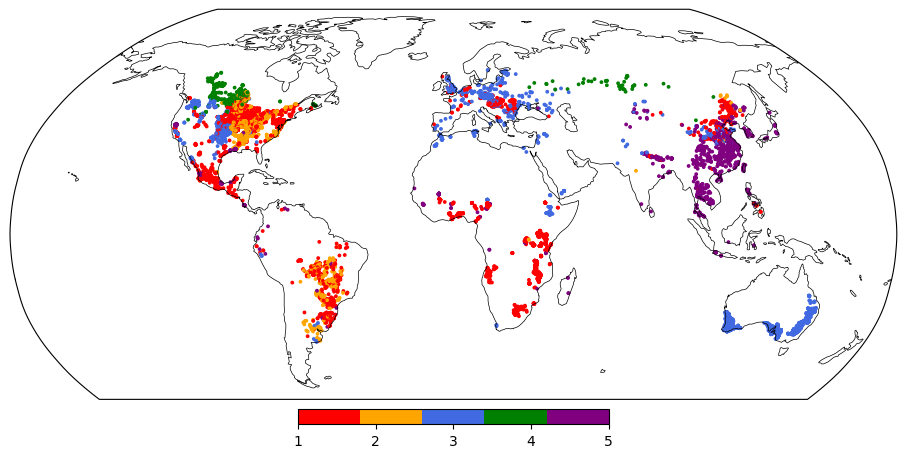

In [35]:
plt.figure(figsize=(10, 5), dpi=100)
# crs = ccrs.PlateCarree(central_longitude=0.0, globe=None)
crs = ccrs.Robinson(central_longitude=0, globe=None)
ax = plt.axes(projection=crs)
ax._autoscaleXon = False
ax._autoscaleYon = False

ax.coastlines(linewidth=0.5)

gdf_ = gdf[gdf['crop_type_domain'] != 'nocrop'].reset_index(drop=True)
print(len(gdf_))

cmap = mpl.colors.ListedColormap(['red', 'orange', 'royalblue', 'green', 'purple'], 'indexed')
plt_points = ax.scatter(gdf_['longitude'], gdf_['latitude'], c=gdf_['crop_type_domain_id'],
                        marker='o', s=3, cmap=cmap,
                        transform=ccrs.PlateCarree())
plt.colorbar(plt_points, cmap=cmap, orientation='horizontal', ticklocation='bottom', spacing='proportional', extend='neither', shrink=0.32, pad=0.02)

extent=[-179.999, 179.999, -60, 90]
ax.set_extent(extent, crs=ccrs.PlateCarree())
plt.tight_layout()

plt.savefig('./figure/sample-level_maps/samples_crop_type_domain_id_{}.jpg'.format(top_or_sub), bbox_inches='tight', dpi=600)
plt.show()

### Biome types recategorize
1 Tropical forests [1,2,3] \
2 Temperate forests [4,5] \
3 Boreal forests [6] \
4 Tropical savannahs and grasslands [7 + 10,12 in -23 ~ 23] \
5 Temperate grasslands and shrublands [8 + 10,12 in -50 ~ -23 and 23 ~ 50] \
6 Deserts [13] \
7 Tundra [11] \
8 Croplands [determined by landcover map ID:12]\
9 Wetlands [9, 14] and [determined by landcover map ID:11]

subdivide: [10, 12] -> divided into tropical/temperate/boreal by latitude (split at 23 and 50)

In [36]:
# adapt from Carvalhais et al., 2014, Nature
biome_type_list = []
biome_type_name_list = []
for i in range(len(gdf['BIOME_NUM'])):
    biome_type = 0
    biome_type_name = 'NA'
    # if gdf['landcover'][i] in [12]: # or [12,14]
    #     biome_type = 8
    #     biome_type_name = 'Croplands'
    if gdf['crop_type_domain'][i] != 'nocrop':
        biome_type = 8
        biome_type_name = 'Croplands'
    elif gdf['lc_name_modis'][i] == 'Permanent Wetlands':
        biome_type = 9
        biome_type_name = 'Wetlands'
    elif gdf['BIOME_NUM'][i] in [1,2,3]:
        biome_type = 1
        biome_type_name = 'Tropical forests'
    elif gdf['BIOME_NUM'][i] in [4,5]:
        biome_type = 2
        biome_type_name = 'Temperate forests'
    elif gdf['BIOME_NUM'][i] in [6]:
        biome_type = 3
        biome_type_name = 'Boreal forests'
    elif gdf['BIOME_NUM'][i] in [7] or (gdf['BIOME_NUM'][i] in [10,12] and (gdf['latitude'][i] >= -23 and gdf['latitude'][i] <= 23)):
        biome_type = 4
        biome_type_name = 'Tropical savannahs and grasslands'
    elif gdf['BIOME_NUM'][i] in [8] or (gdf['BIOME_NUM'][i] in [10,12] and ((gdf['latitude'][i] >= -50 and gdf['latitude'][i] < -23) or (gdf['latitude'][i] > 23 and gdf['latitude'][i] <= 50))):
        biome_type = 5
        biome_type_name = 'Temperate grasslands and shrublands'
    elif gdf['BIOME_NUM'][i] in [13]:
        biome_type = 6
        biome_type_name = 'Deserts and xeric shrublands'
    elif gdf['BIOME_NUM'][i] in [11]:
        biome_type = 7
        biome_type_name = 'Tundra'
    elif gdf['BIOME_NUM'][i] in [9, 14]:
        biome_type = 9
        biome_type_name = 'Wetlands'
    else:
        pass
    biome_type_list.append(biome_type)
    biome_type_name_list.append(biome_type_name)
gdf['biome_type'] = biome_type_list
gdf['biome_type_name'] = biome_type_name_list

print(gdf.shape)
print(list(gdf.columns))
gdf.head()

(71863, 53)
['profile_id', 'latitude', 'longitude', 'socs', 'geometry', 'UID', 'GID_0', 'NAME_0', 'GID_1', 'NAME_1', 'GID_2', 'NAME_2', 'GID_3', 'NAME_3', 'GID_4', 'NAME_4', 'IncomeGroup', 'biome_OpenLandMap', 'lc_id_modis', 'lc_name_modis', 'OBJECTID', 'ECO_NAME', 'BIOME_NUM', 'BIOME_NAME', 'REALM', 'ECO_BIOME_', 'NNH', 'ECO_ID', 'SHAPE_LENG', 'SHAPE_AREA', 'NNH_NAME', 'COLOR', 'COLOR_BIO', 'COLOR_NNH', 'permafrost_CODE', 'permafrost_COMBO', 'permafrost_RELICT', 'permafrost_EXTENT', 'permafrost_CONTENT', 'permafrost_LANDFORM', 'is_permafrost', 'permafrost_EXTENT_id', 'crop_prop_maize', 'crop_prop_soybean', 'crop_prop_wheat_winter', 'crop_prop_wheat_spring', 'crop_prop_rice', 'crop_type_domain', 'crop_type_domain_id', 'crop_prop_sum', 'crop_prop_domain', 'biome_type', 'biome_type_name']


,profile_id,latitude,longitude,socs,geometry,UID,GID_0,NAME_0,GID_1,NAME_1,...,crop_prop_soybean,crop_prop_wheat_winter,crop_prop_wheat_spring,crop_prop_rice,crop_type_domain,crop_type_domain_id,crop_prop_sum,crop_prop_domain,biome_type,biome_type_name
0,36897,50.649889,4.666901,0.347342,POINT (4.66690 50.64989),46721.0,BEL,Belgium,BEL.3_1,Wallonie,...,0.0,0.2823,0.0056,0.0,wheat_winter,3,0.3291,0.2823,8,Croplands
1,36898,50.583962,4.462114,0.392287,POINT (4.46211 50.58396),46742.0,BEL,Belgium,BEL.3_1,Wallonie,...,0.0,0.2156,0.0000,0.0,wheat_winter,3,0.2581,0.2156,8,Croplands
2,36899,50.597876,4.687607,0.561489,POINT (4.68761 50.59788),46752.0,BEL,Belgium,BEL.3_1,Wallonie,...,0.0,0.2431,0.0000,0.0,wheat_winter,3,0.2711,0.2431,8,Croplands
3,36900,50.633599,4.681783,0.592344,POINT (4.68178 50.63360),46752.0,BEL,Belgium,BEL.3_1,Wallonie,...,0.0,0.2823,0.0056,0.0,wheat_winter,3,0.3291,0.2823,8,Croplands
4,36901,50.623204,4.466035,0.641663,POINT (4.46603 50.62320),46742.0,BEL,Belgium,BEL.3_1,Wallonie,...,0.0,0.1285,0.0000,0.0,wheat_winter,3,0.2077,0.1285,8,Croplands


## Assign fr_bnpp at top- and subsoil layers for all soil samples

In [39]:
df_root = pd.read_csv('./data/root_profiles/df_root_distribution_all.csv')
print(df_root.shape)
df_root.head(3)

(1732, 4)


,lat,lon,frbnpp_0to30,frbnpp_30to100
0,-46.516700,-71.050000,0.656395,0.302689
1,-45.683333,-70.266667,0.783590,0.197534
2,-45.450000,-69.830000,0.931923,0.059762


In [40]:
gdf_root = gpd.GeoDataFrame(df_root, geometry=gpd.points_from_xy(df_root['lon'], df_root['lat']), crs=4326)
print(gdf_root.shape)
gdf_root.head(2)

(1732, 5)


,lat,lon,frbnpp_0to30,frbnpp_30to100,geometry
0,-46.516700,-71.050000,0.656395,0.302689,POINT (-71.05000 -46.51670)
1,-45.683333,-70.266667,0.783590,0.197534,POINT (-70.26667 -45.68333)


In [41]:
gdf_root = gpd.sjoin(left_df=gdf_root, right_df=gdf_ecoregion, how='inner', op='intersects')
gdf_root = gdf_root.drop('index_right', axis=1)

gdf_root = gdf_root[gdf_root['frbnpp_30to100'] >= 0.01].reset_index(drop=True)

print(gdf_root.shape)
print(list(gdf_root.columns))
gdf_root.head(2)

(1613, 20)
['lat', 'lon', 'frbnpp_0to30', 'frbnpp_30to100', 'geometry', 'OBJECTID', 'ECO_NAME', 'BIOME_NUM', 'BIOME_NAME', 'REALM', 'ECO_BIOME_', 'NNH', 'ECO_ID', 'SHAPE_LENG', 'SHAPE_AREA', 'NNH_NAME', 'COLOR', 'COLOR_BIO', 'COLOR_NNH', 'LICENSE']


,lat,lon,frbnpp_0to30,frbnpp_30to100,geometry,OBJECTID,ECO_NAME,BIOME_NUM,BIOME_NAME,REALM,ECO_BIOME_,NNH,ECO_ID,SHAPE_LENG,SHAPE_AREA,NNH_NAME,COLOR,COLOR_BIO,COLOR_NNH,LICENSE
0,-46.516700,-71.050000,0.656395,0.302689,POINT (-71.05000 -46.51670),561.0,Patagonian steppe,8.0,"Temperate Grasslands, Savannas & Shrublands",Neotropic,NO08,2,578,156.277392,66.772362,Nature Could Reach Half Protected,#E69800,#FEFF73,#7BC141,CC-BY 4.0
1,-45.683333,-70.266667,0.783590,0.197534,POINT (-70.26667 -45.68333),561.0,Patagonian steppe,8.0,"Temperate Grasslands, Savannas & Shrublands",Neotropic,NO08,2,578,156.277392,66.772362,Nature Could Reach Half Protected,#E69800,#FEFF73,#7BC141,CC-BY 4.0


In [42]:
df_root_agg_biome = gdf_root.groupby('BIOME_NUM', as_index=False).agg({
    'BIOME_NAME': 'first',
    'OBJECTID': 'count',
    'frbnpp_0to30': [Q05, 'mean', 'median', Q95],
    'frbnpp_30to100': [Q05, 'mean', 'median', Q95]
}).rename(columns={'OBJECTID': 'count'})

print(df_root_agg_biome.shape)
df_root_agg_biome.round(3)

(14, 11)


BIOME_NUM                                         BIOME_NAME count  \
                                                          first count   
0        1.0     Tropical & Subtropical Moist Broadleaf Forests    98   
1        2.0       Tropical & Subtropical Dry Broadleaf Forests    14   
2        3.0          Tropical & Subtropical Coniferous Forests     1   
3        4.0                Temperate Broadleaf & Mixed Forests   331   
4        5.0                          Temperate Conifer Forests   217   
5        6.0                               Boreal Forests/Taiga    51   
6        7.0  Tropical & Subtropical Grasslands, Savannas & ...   257   
7        8.0        Temperate Grasslands, Savannas & Shrublands   334   
8        9.0                      Flooded Grasslands & Savannas     7   
9       10.0                    Montane Grasslands & Shrublands    12   
10      11.0                                             Tundra    14   
11      12.0           Mediterranean Forests, Woodlands & Scrub    84   
12      13.0                         Deserts & Xeric Shrublands   188   
13      14.0                                          Mangroves     5   

   frbnpp_0to30                      frbnpp_30to100                       
            Q05   mean median    Q95            Q05   mean median    Q95  
0         0.233  0.684  0.752  0.934          0.052  0.219  0.198  0.417  
1         0.271  0.594  0.597  0.893          0.091  0.279  0.348  0.435  
2         0.241  0.241  0.241  0.241          0.360  0.360  0.360  0.360  
3         0.309  0.676  0.695  0.956          0.039  0.271  0.263  0.483  
4         0.363  0.677  0.684  0.953          0.047  0.275  0.285  0.473  
5         0.573  0.805  0.851  0.974          0.026  0.176  0.123  0.368  
6         0.247  0.549  0.536  0.876          0.119  0.336  0.365  0.436  
7         0.212  0.554  0.540  0.892          0.097  0.316  0.355  0.442  
8         0.321  0.678  0.762  0.867          0.132  0.245  0.227  0.399  
9         0.318  0.698  0.739  0.931          0.056  0.230  0.244  0.426  
10        0.895  0.949  0.957  0.984          0.015  0.047  0.042  0.098  
11        0.159  0.546  0.499  0.948          0.046  0.297  0.327  0.480  
12        0.175  0.556  0.557  0.936          0.064  0.309  0.335  0.468  
13        0.339  0.597  0.602  0.865          0.116  0.290  0.340  0.414

In [43]:
df_root_agg_eco = gdf_root.groupby('ECO_ID', as_index=False).agg({'OBJECTID': 'count', 'frbnpp_0to30': 'mean', 'frbnpp_30to100': 'mean'}).rename(columns={'OBJECTID': 'count'})
df_root_agg_eco = df_root_agg_eco[df_root_agg_eco['count'] > 1].reset_index(drop=True)

print(df_root_agg_eco.shape)
df_root_agg_eco.head()

(170, 4)


,ECO_ID,count,frbnpp_0to30,frbnpp_30to100
0,8,5,0.334710,0.327866
1,11,9,0.710538,0.233310
2,38,4,0.366270,0.498731
3,39,72,0.465585,0.379429
4,42,25,0.665233,0.293035


In [44]:
frbnpp_0to30_list = []
frbnpp_30to100_list = []
for i in tqdm(range(len(gdf))):
    frbnpp_0to30 = 0
    frbnpp_30to100 = 0
    ECO_ID = gdf['ECO_ID'][i]
    BIOME_NUM = gdf['BIOME_NUM'][i]
    df_root_agg_eco_sub = df_root_agg_eco[df_root_agg_eco['ECO_ID'] == ECO_ID].reset_index(drop=True)
    if len(df_root_agg_eco_sub) > 0:
        frbnpp_0to30 = df_root_agg_eco_sub['frbnpp_0to30'].iloc[0]
        frbnpp_30to100 = df_root_agg_eco_sub['frbnpp_30to100'].iloc[0]
    else:
        df_root_agg_biome_sub = df_root_agg_biome[df_root_agg_biome['BIOME_NUM'] == BIOME_NUM].reset_index(drop=True)
        frbnpp_0to30 = df_root_agg_biome_sub['frbnpp_0to30']['mean'].iloc[0]
        frbnpp_30to100 = df_root_agg_biome_sub['frbnpp_30to100']['mean'].iloc[0]
    frbnpp_0to30_list.append(frbnpp_0to30)
    frbnpp_30to100_list.append(frbnpp_30to100)
gdf['frbnpp_0to30'] = frbnpp_0to30_list
gdf['frbnpp_30to100'] = frbnpp_30to100_list

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 71862/71862 [01:07<00:00, 1058.43it/s]


## Filter by location accuracy

In [45]:
df_profile = pd.read_csv('./data/wosis_2019/wosis_201909_profiles.tsv', sep='\t')
df_profile['profile_id'] = df_profile['profile_id'].astype(str)

print(df_profile.shape)
print(list(df_profile.columns))
df_profile.head(2)

(196498, 23)
['profile_id', 'dataset_id', 'country_id', 'country_name', 'geom_accuracy', 'latitude', 'longitude', 'dsds', 'cfao_version', 'cfao_major_group_code', 'cfao_major_group', 'cfao_soil_unit_code', 'cfao_soil_unit', 'cwrb_version', 'cwrb_reference_soil_group_code', 'cwrb_reference_soil_group', 'cwrb_prefix_qualifier', 'cwrb_suffix_qualifier', 'cstx_version', 'cstx_order_name', 'cstx_suborder', 'cstx_great_group', 'cstx_subgroup']


,profile_id,dataset_id,country_id,country_name,geom_accuracy,latitude,longitude,dsds,cfao_version,cfao_major_group_code,...,cwrb_version,cwrb_reference_soil_group_code,cwrb_reference_soil_group,cwrb_prefix_qualifier,cwrb_suffix_qualifier,cstx_version,cstx_order_name,cstx_suborder,cstx_great_group,cstx_subgroup
0,36897,{BE-UplandsI},BE,Belgium,0.000001,50.649889,4.666901,100.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,36898,{BE-UplandsI},BE,Belgium,0.000001,50.583962,4.462114,97.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [46]:
gdf = pd.merge(left=gdf, right=df_profile[['profile_id', 'geom_accuracy', 'dsds', 'country_name']], on='profile_id', how='left')
print(gdf.shape)
print(list(gdf.columns))

(71862, 59)
['profile_id', 'latitude', 'longitude', 'socs', 'geometry', 'UID', 'GID_0', 'NAME_0', 'GID_1', 'NAME_1', 'GID_2', 'NAME_2', 'GID_3', 'NAME_3', 'GID_4', 'NAME_4', 'IncomeGroup', 'biome_OpenLandMap', 'lc_id_modis', 'lc_name_modis', 'OBJECTID', 'ECO_NAME', 'BIOME_NUM', 'BIOME_NAME', 'REALM', 'ECO_BIOME_', 'NNH', 'ECO_ID', 'SHAPE_LENG', 'SHAPE_AREA', 'NNH_NAME', 'COLOR', 'COLOR_BIO', 'COLOR_NNH', 'permafrost_CODE', 'permafrost_COMBO', 'permafrost_RELICT', 'permafrost_EXTENT', 'permafrost_CONTENT', 'permafrost_LANDFORM', 'is_permafrost', 'permafrost_EXTENT_id', 'crop_prop_maize', 'crop_prop_soybean', 'crop_prop_wheat_winter', 'crop_prop_wheat_spring', 'crop_prop_rice', 'crop_type_domain', 'crop_type_domain_id', 'crop_prop_sum', 'crop_prop_domain', 'biome_type', 'biome_type_name', 'harvest_index', 'frbnpp_0to30', 'frbnpp_30to100', 'geom_accuracy', 'dsds', 'country_name']


In [47]:
print(np.max(gdf['geom_accuracy']))

0.015


## Merge sample data with other environmental covariates

In [48]:
fn_cov_list = os.listdir(dir_cov_data)
pprint(fn_cov_list)

['samples_agb.csv',
 'samples_agb_unc.csv',
 'samples_aridity.csv',
 'samples_bgb.csv',
 'samples_bgb_unc.csv',
 'samples_bio01.csv',
 'samples_bio02.csv',
 'samples_bio03.csv',
 'samples_bio04.csv',
 'samples_bio05.csv',
 'samples_bio06.csv',
 'samples_bio07.csv',
 'samples_bio08.csv',
 'samples_bio09.csv',
 'samples_bio10.csv',
 'samples_bio11.csv',
 'samples_bio12.csv',
 'samples_bio13.csv',
 'samples_bio14.csv',
 'samples_bio15.csv',
 'samples_bio16.csv',
 'samples_bio17.csv',
 'samples_bio18.csv',
 'samples_bio19.csv',
 'samples_biome.csv',
 'samples_cti.csv',
 'samples_elev.csv',
 'samples_evi.csv',
 'samples_landcover.csv',
 'samples_landcover_prop.csv',
 'samples_npp_modis.csv',
 'samples_pop.csv',
 'samples_rmf.csv',
 'samples_roughness.csv',
 'samples_slp.csv',
 'samples_smp.csv',
 'samples_spi.csv',
 'samples_tpi.csv',
 'samples_tri.csv',
 'samples_vrm.csv',
 'soilgrid']


In [49]:
df_covar = pd.read_csv('{}/samples_npp_modis.csv'.format(dir_cov_data))
gdf = merge_covar(df=gdf, df_covar=df_covar, covar_name='npp_modis', on_key='profile_id')

df_covar = pd.read_csv('{}/samples_rmf.csv'.format(dir_cov_data))
gdf = merge_covar(df=gdf, df_covar=df_covar, covar_name='rmf', on_key='profile_id')

df_covar = pd.read_csv('{}/samples_agb.csv'.format(dir_cov_data))
gdf = merge_covar(df=gdf, df_covar=df_covar, covar_name='agb', on_key='profile_id')

df_covar = pd.read_csv('{}/samples_bgb.csv'.format(dir_cov_data))
gdf = merge_covar(df=gdf, df_covar=df_covar, covar_name='bgb', on_key='profile_id')

df_covar = pd.read_csv('{}/samples_smp.csv'.format(dir_cov_data))
gdf = merge_covar(df=gdf, df_covar=df_covar, covar_name='smp', on_key='profile_id')

for bio_id in  ['bio01', 'bio02', 'bio03', 'bio04', 'bio05', 'bio06', 'bio07', 'bio08', 'bio09', 'bio10', 'bio11', 'bio12', 'bio13', 'bio14', 'bio15', 'bio16', 'bio17', 'bio18', 'bio19']:
    df_covar = pd.read_csv('{}/samples_{}.csv'.format(dir_cov_data, bio_id))
    gdf = merge_covar(df=gdf, df_covar=df_covar, covar_name=bio_id, on_key='profile_id')
    
df_covar = pd.read_csv('{}/samples_aridity.csv'.format(dir_cov_data))
gdf = merge_covar(df=gdf, df_covar=df_covar, covar_name='aridity', on_key='profile_id')

for topo_varname in ['elev', 'slp', 'cti', 'tri', 'vrm', 'roughness', 'tpi', 'spi']:
    df_covar = pd.read_csv('{}/samples_{}.csv'.format(dir_cov_data, topo_varname))
    gdf = merge_covar(df=gdf, df_covar=df_covar, covar_name=topo_varname, on_key='profile_id')

df_covar = pd.read_csv('{}/samples_evi.csv'.format(dir_cov_data))
gdf = merge_covar(df=gdf, df_covar=df_covar, covar_name='evi', on_key='profile_id')

df_covar = pd.read_csv('{}/samples_pop.csv'.format(dir_cov_data))
gdf = merge_covar(df=gdf, df_covar=df_covar, covar_name='pop', on_key='profile_id')

print(gdf.shape)
print(list(gdf.columns))

(71862, 94)
['profile_id', 'latitude', 'longitude', 'socs', 'geometry', 'UID', 'GID_0', 'NAME_0', 'GID_1', 'NAME_1', 'GID_2', 'NAME_2', 'GID_3', 'NAME_3', 'GID_4', 'NAME_4', 'IncomeGroup', 'biome_OpenLandMap', 'lc_id_modis', 'lc_name_modis', 'OBJECTID', 'ECO_NAME', 'BIOME_NUM', 'BIOME_NAME', 'REALM', 'ECO_BIOME_', 'NNH', 'ECO_ID', 'SHAPE_LENG', 'SHAPE_AREA', 'NNH_NAME', 'COLOR', 'COLOR_BIO', 'COLOR_NNH', 'permafrost_CODE', 'permafrost_COMBO', 'permafrost_RELICT', 'permafrost_EXTENT', 'permafrost_CONTENT', 'permafrost_LANDFORM', 'is_permafrost', 'permafrost_EXTENT_id', 'crop_prop_maize', 'crop_prop_soybean', 'crop_prop_wheat_winter', 'crop_prop_wheat_spring', 'crop_prop_rice', 'crop_type_domain', 'crop_type_domain_id', 'crop_prop_sum', 'crop_prop_domain', 'biome_type', 'biome_type_name', 'harvest_index', 'frbnpp_0to30', 'frbnpp_30to100', 'geom_accuracy', 'dsds', 'country_name', 'npp_modis', 'rmf', 'agb', 'bgb', 'smp', 'bio01', 'bio02', 'bio03', 'bio04', 'bio05', 'bio06', 'bio07', 'bio08

In [50]:
dir_soilgrid = './data/covariates/cov_data_2024/covs/soilgrid/'

soil_property_name = 'bdod'
df_samples_bdod = get_soil_property_0to100(df_dir=dir_soilgrid, soil_property_name=soil_property_name)
df_samples_bdod[df_samples_bdod.columns[1:]] = df_samples_bdod[df_samples_bdod.columns[1:]] * 0.01

soil_property_name = 'cec'
df_samples_cec = get_soil_property_0to100(df_dir=dir_soilgrid, soil_property_name=soil_property_name)
df_samples_cec[df_samples_cec.columns[1:]] = df_samples_cec[df_samples_cec.columns[1:]] * 0.1

soil_property_name = 'cfvo'
df_samples_cfvo = get_soil_property_0to100(df_dir=dir_soilgrid, soil_property_name=soil_property_name)
df_samples_cfvo[df_samples_cfvo.columns[1:]] = df_samples_cfvo[df_samples_cfvo.columns[1:]] * 0.1

soil_property_name = 'clay'
df_samples_clay = get_soil_property_0to100(df_dir=dir_soilgrid, soil_property_name=soil_property_name)
df_samples_clay[df_samples_clay.columns[1:]] = df_samples_clay[df_samples_clay.columns[1:]] * 0.1

soil_property_name = 'nitrogen'
df_samples_nitrogen = get_soil_property_0to100(df_dir=dir_soilgrid, soil_property_name=soil_property_name)
# df_samples_nitrogen[df_samples_nitrogen.columns[1:]] = df_samples_nitrogen[df_samples_nitrogen.columns[1:]] * 0.01
df_samples_nitrogen[df_samples_nitrogen.columns[1:]] = df_samples_nitrogen[df_samples_nitrogen.columns[1:]] * 0.001

soil_property_name = 'ocd'
df_samples_ocd = get_soil_property_0to100(df_dir=dir_soilgrid, soil_property_name=soil_property_name)
df_samples_ocd[df_samples_ocd.columns[1:]] = df_samples_ocd[df_samples_ocd.columns[1:]] * 0.1

soil_property_name = 'phh2o'
df_samples_phh2o = get_soil_property_0to100(df_dir=dir_soilgrid, soil_property_name=soil_property_name)
df_samples_phh2o[df_samples_phh2o.columns[1:]] = df_samples_phh2o[df_samples_phh2o.columns[1:]] * 0.1

soil_property_name = 'sand'
df_samples_sand = get_soil_property_0to100(df_dir=dir_soilgrid, soil_property_name=soil_property_name)
df_samples_sand[df_samples_sand.columns[1:]] = df_samples_sand[df_samples_sand.columns[1:]] * 0.1

soil_property_name = 'silt'
df_samples_silt = get_soil_property_0to100(df_dir=dir_soilgrid, soil_property_name=soil_property_name)
df_samples_silt[df_samples_silt.columns[1:]] = df_samples_silt[df_samples_silt.columns[1:]] * 0.1

soil_property_name = 'soc'
df_samples_soc = get_soil_property_0to100(df_dir=dir_soilgrid, soil_property_name=soil_property_name, only_2_layers=False)
df_samples_soc[df_samples_soc.columns[1:]] = df_samples_soc[df_samples_soc.columns[1:]] * 0.1

In [51]:
gdf = pd.merge(left=gdf, right=df_samples_bdod, on='profile_id', how='left')
gdf = pd.merge(left=gdf, right=df_samples_cec, on='profile_id', how='left')
gdf = pd.merge(left=gdf, right=df_samples_cfvo, on='profile_id', how='left')
gdf = pd.merge(left=gdf, right=df_samples_clay, on='profile_id', how='left')
gdf = pd.merge(left=gdf, right=df_samples_nitrogen, on='profile_id', how='left')
gdf = pd.merge(left=gdf, right=df_samples_ocd, on='profile_id', how='left')
gdf = pd.merge(left=gdf, right=df_samples_phh2o, on='profile_id', how='left')
gdf = pd.merge(left=gdf, right=df_samples_sand, on='profile_id', how='left')
gdf = pd.merge(left=gdf, right=df_samples_silt, on='profile_id', how='left')
gdf = pd.merge(left=gdf, right=df_samples_soc, on='profile_id', how='left')

In [52]:
colname_new_list = []
for colname in list(gdf.columns):
    colname_new = colname
    if 'pred' in colname:
        str_list = colname.split('_')
        colname_new = '{}_{}'.format(str_list[0], str_list[2])
    colname_new_list.append(colname_new)
gdf.columns = colname_new_list

# Extra carbon input by fertilization in Croplands

Fertilizer types:\
anhydrous ammonia (AA), ammonium nitrate (AN), ammonium sulphate (AS),\
calcium ammonium nitrate (CAN), nitrogen solutions (NS), other N straight (ONS),\
Urea, ammonium 
phosphate (AP)\
 N K compounds (NK), N P K compounds (NPK), other NP (ONP), crop residues (CR) and
manure (MA).

In [83]:
crop_name_list = []
fn_list = glob.glob('Z:/data_hub/cropland/fertilizer/N_application/N_application_*.h5')
for fn in fn_list:
    crop_name = fn.split('\\')[-1].split('_')[3]
    crop_name_list.append(crop_name)
print(crop_name_list)

['Barley', 'Cassava', 'Cotton', 'Fruits', 'Groundnut', 'Maize', 'Millet', 'Oilpalm', 'Others crops', 'Potato', 'Rapeseed', 'Rice', 'Rye', 'Sorghum', 'Soybean', 'Sugarbeet', 'Sugarcane', 'Sunflower', 'Sweetpotato', 'Vegetables', 'Wheat']


In [84]:
fertilizer_type_name_list = ['AA', 'AN', 'AP', 'AS', 'CAN', 'NK', 'NPK', 'NS', 'ONP', 'ONS', 'Urea', 'CR', 'MA']
print(len(fertilizer_type_name_list), fertilizer_type_name_list)

13 ['AA', 'AN', 'AP', 'AS', 'CAN', 'NK', 'NPK', 'NS', 'ONP', 'ONS', 'Urea', 'CR', 'MA']


In [85]:
for crop_name in tqdm(crop_name_list):
    # print(crop_name, flush=True)
    ds_N_rate_one_crop = rxr.open_rasterio('Z:/data_hub/cropland/fertilizer/N_application/N_application_rate_{}_1961-2020.h5'.format(crop_name))
    ds_N_rate_one_crop = ds_N_rate_one_crop.rename(x='y', y='x', band='time')
    ds_N_rate_one_crop.coords['x'] = np.arange(-180+0.5*5/60, 180, 5/60)
    ds_N_rate_one_crop.coords['y'] = -np.arange(-90+0.5*5/60, 90, 5/60)
    ds_N_rate_one_crop.coords['time'] = np.arange(1961, 2020+1, 1)
    ds_N_rate_one_crop.rio.set_spatial_dims(x_dim='y', y_dim='x', inplace=True).rio.write_coordinate_system(inplace=True)
    ds_N_rate_one_crop.rio.write_crs(4326, inplace=True)
    ds_N_rate_one_crop.attrs = {'Autor': 'Lei Zhang (NJU)'}
    
    for fertilizer_type_name in fertilizer_type_name_list:
        for surface_or_deep in ['surface', 'deep']:
            # Extract the N fertilizer data in the year of 2010 (index: 49) as an example
            sample_values_fertilizer = extract_sample_values(df_samples=gdf, raster=ds_N_rate_one_crop['{}_{}'.format(fertilizer_type_name, surface_or_deep)][49], x_name='longitude', y_name='latitude', method='nearest')
            sample_values_fertilizer[np.isnan(sample_values_fertilizer)] = 0
            sample_values_fertilizer = sample_values_fertilizer * 0.0001  # kg / ha -> kg / m2
            gdf['N_fer_{}_{}_{}'.format(crop_name, fertilizer_type_name, surface_or_deep)] = sample_values_fertilizer

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [03:15<00:00,  9.30s/it]


In [86]:
N_fer_total_surface_list = np.zeros(len(gdf))
N_fer_total_deep_list = np.zeros(len(gdf))
for crop_name in crop_name_list:
    for fertilizer_type_name in fertilizer_type_name_list:
        N_fer_total_surface_list += gdf['N_fer_{}_{}_{}'.format(crop_name, fertilizer_type_name, 'surface')]
        N_fer_total_deep_list += gdf['N_fer_{}_{}_{}'.format(crop_name, fertilizer_type_name, 'deep')]
gdf['N_fer_total_surface'] = N_fer_total_surface_list
gdf['N_fer_total_deep'] = N_fer_total_deep_list
gdf['N_fer_total'] = gdf['N_fer_total_surface'] + gdf['N_fer_total_deep']

N_fer_CR_surface_list = np.zeros(len(gdf))
N_fer_CR_deep_list = np.zeros(len(gdf))
for crop_name in crop_name_list:
    N_fer_CR_surface_list += gdf['N_fer_{}_{}_{}'.format(crop_name, 'CR', 'surface')]
    N_fer_CR_deep_list += gdf['N_fer_{}_{}_{}'.format(crop_name, 'CR', 'deep')]
gdf['N_fer_CR_surface'] = N_fer_CR_surface_list
gdf['N_fer_CR_deep'] = N_fer_CR_deep_list
gdf['N_fer_CR'] = gdf['N_fer_CR_surface'] + gdf['N_fer_CR_deep']

N_fer_MA_surface_list = np.zeros(len(gdf))
N_fer_MA_deep_list = np.zeros(len(gdf))
for crop_name in crop_name_list:
    N_fer_MA_surface_list += gdf['N_fer_{}_{}_{}'.format(crop_name, 'MA', 'surface')]
    N_fer_MA_deep_list += gdf['N_fer_{}_{}_{}'.format(crop_name, 'MA', 'deep')]
gdf['N_fer_MA_surface'] = N_fer_MA_surface_list
gdf['N_fer_MA_deep'] = N_fer_MA_deep_list
gdf['N_fer_MA'] = gdf['N_fer_MA_surface'] + gdf['N_fer_MA_deep']

gdf['N_fer_total_no_CR_surface'] = gdf['N_fer_total_surface'] - gdf['N_fer_CR_surface']
gdf['N_fer_total_no_CR_deep'] = gdf['N_fer_total_deep'] - gdf['N_fer_CR_deep']
gdf['N_fer_total_no_CR'] = gdf['N_fer_total'] - gdf['N_fer_CR']

CN_ratio_FAO = 15
# gdf['c_input_by_fertilization'] = gdf['N_fer_total_no_CR'] * CN_ratio_FAO
gdf['c_input_by_fertilization_surface'] = gdf['N_fer_MA_surface'] * CN_ratio_FAO
gdf['c_input_by_fertilization_deep'] = gdf['N_fer_MA_deep'] * CN_ratio_FAO
gdf['c_input_by_fertilization'] = gdf['N_fer_MA'] * CN_ratio_FAO
gdf['c_input_by_fertilization_surface'] = gdf['c_input_by_fertilization_surface'].where(gdf['crop_type_domain'] != 'nocrop', 0)
gdf['c_input_by_fertilization_deep'] = gdf['c_input_by_fertilization_deep'].where(gdf['crop_type_domain'] != 'nocrop', 0)
gdf['c_input_by_fertilization'] = gdf['c_input_by_fertilization'].where(gdf['crop_type_domain'] != 'nocrop', 0)

In [87]:
# gdf_ = gdf[gdf['N_fer_total'] > 0].reset_index(drop=True)
gdf_ = gdf[gdf['crop_type_domain'] != 'nocrop'].reset_index(drop=True)

gdf_[
    ['c_input_by_fertilization', 'c_input_by_fertilization_surface', 'c_input_by_fertilization_deep', 'N_fer_total_no_CR', 'N_fer_total_no_CR_surface', 'N_fer_total_no_CR_deep', 'N_fer_total', 'N_fer_total_surface', 'N_fer_total_deep', 'N_fer_CR', 'N_fer_CR_surface', 'N_fer_CR_deep', 'N_fer_MA', 'N_fer_MA_surface', 'N_fer_MA_deep']
].describe().round(3)

,c_input_by_fertilization,c_input_by_fertilization_surface,c_input_by_fertilization_deep,N_fer_total_no_CR,N_fer_total_no_CR_surface,N_fer_total_no_CR_deep,N_fer_total,N_fer_total_surface,N_fer_total_deep,N_fer_CR,N_fer_CR_surface,N_fer_CR_deep,N_fer_MA,N_fer_MA_surface,N_fer_MA_deep
count,21017.000,21017.000,21017.000,21017.000,21017.000,21017.000,21017.000,21017.000,21017.000,21017.000,21017.000,21017.000,21017.000,21017.000,21017.000
mean,0.444,0.057,0.387,0.108,0.054,0.054,0.146,0.060,0.086,0.038,0.006,0.032,0.030,0.004,0.026
std,0.638,0.222,0.588,0.106,0.073,0.051,0.120,0.077,0.065,0.031,0.018,0.027,0.043,0.015,0.039
min,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,0.033,0.000,0.023,0.023,0.010,0.012,0.055,0.014,0.037,0.019,0.000,0.014,0.002,0.000,0.002
50%,0.131,0.000,0.110,0.085,0.039,0.045,0.118,0.043,0.074,0.033,0.000,0.029,0.009,0.000,0.007
75%,0.547,0.000,0.437,0.154,0.076,0.086,0.205,0.078,0.122,0.051,0.000,0.042,0.036,0.000,0.029
max,5.180,3.655,4.342,1.567,1.319,0.528,1.688,1.319,0.573,0.451,0.283,0.450,0.345,0.244,0.289


21017


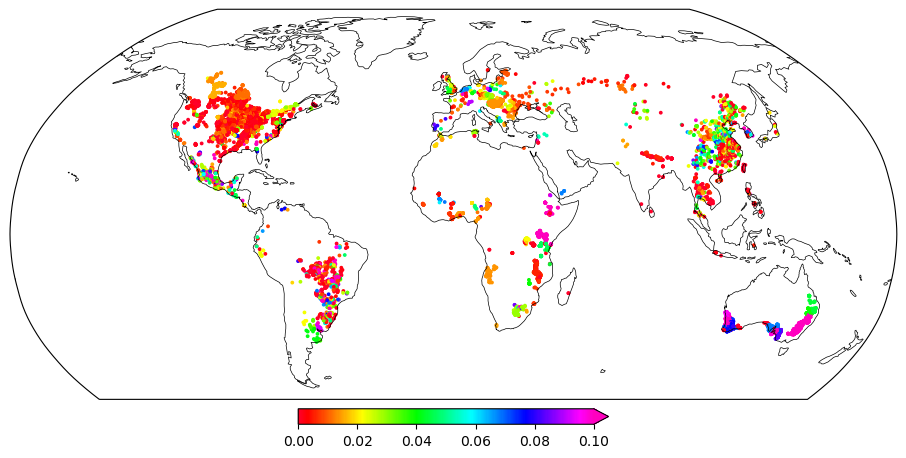

In [89]:
plt.figure(figsize=(10, 5), dpi=100)
# crs = ccrs.PlateCarree(central_longitude=0.0, globe=None)
crs = ccrs.Robinson(central_longitude=0, globe=None)
ax = plt.axes(projection=crs)
ax._autoscaleXon = False
ax._autoscaleYon = False

ax.coastlines(linewidth=0.5)

gdf_ = gdf[gdf['crop_type_domain'] != 'nocrop'].reset_index(drop=True)
# gdf_ = gdf.copy()
print(len(gdf_))

cmap = plt.get_cmap('gist_rainbow')
plt_points = ax.scatter(gdf_['longitude'], gdf_['latitude'], c=gdf_['N_fer_MA'],
                        marker='o', s=3, cmap=cmap, vmin=0, vmax=0.1,
                        transform=ccrs.PlateCarree())
plt.colorbar(plt_points, cmap=cmap, orientation='horizontal', ticklocation='auto', spacing='proportional', extend='max', shrink=0.32, pad=0.02)

extent=[-179.999, 179.999, -60, 90]
ax.set_extent(extent, crs=ccrs.PlateCarree())
plt.tight_layout()

plt.savefig('./figure/sample-level_maps/samples_croplands_N_fer_MA_{}.jpg'.format(top_or_sub), bbox_inches='tight', dpi=600)
plt.show()

21017


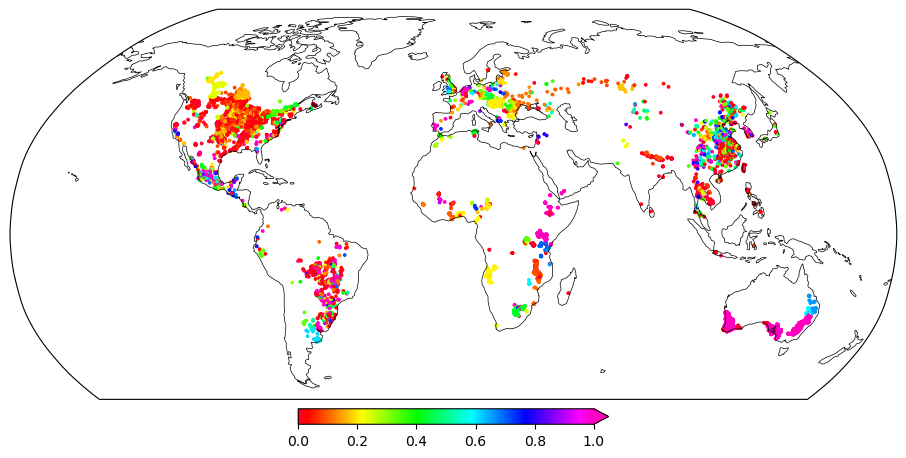

In [90]:
plt.figure(figsize=(10, 5), dpi=100)
# crs = ccrs.PlateCarree(central_longitude=0.0, globe=None)
crs = ccrs.Robinson(central_longitude=0, globe=None)
ax = plt.axes(projection=crs)
ax._autoscaleXon = False
ax._autoscaleYon = False

ax.coastlines(linewidth=0.5)

gdf_ = gdf[gdf['crop_type_domain'] != 'nocrop'].reset_index(drop=True)
# gdf_ = gdf.copy()
print(len(gdf_))

cmap = plt.get_cmap('gist_rainbow')
plt_points = ax.scatter(gdf_['longitude'], gdf_['latitude'], c=gdf_['c_input_by_fertilization'],
                        marker='o', s=3, cmap=cmap, vmin=0, vmax=1,
                        transform=ccrs.PlateCarree())
plt.colorbar(plt_points, cmap=cmap, orientation='horizontal', ticklocation='auto', spacing='proportional', extend='max', shrink=0.32, pad=0.02)

extent=[-179.999, 179.999, -60, 90]
ax.set_extent(extent, crs=ccrs.PlateCarree())
plt.tight_layout()

plt.savefig('./figure/sample-level_maps/samples_croplands_extra_C_input_by_N_fer_MA_{}.jpg'.format(top_or_sub), bbox_inches='tight', dpi=600)
plt.show()

## Set the aboveground residue retention rates (prop_residue_retention)
According to the method described in Wang et al., 2016. Sci Rep (https://doi.org/10.1038/srep19327)

(According to published literature, the above-ground residue retention rates were assumed 30% in 
developing regions such as Asia and Afric , and 60% in other regios).

In [91]:
print(list(np.unique(gdf['IncomeGroup'])))

prop_residue_retention_list = []
for i in range(len(gdf)):
    prop_residue_retention = 1.0
    if gdf['IncomeGroup'][i] in ['Lower middle income', 'Upper middle income']:
        prop_residue_retention = 0.3
    else:
        prop_residue_retention = 0.6
    prop_residue_retention_list.append(prop_residue_retention)
gdf['prop_residue_retention'] = prop_residue_retention_list

# gdf['prop_residue_retention'] = 1.0

print(list(np.unique(gdf['prop_residue_retention'])))

['High income', 'Low income', 'Lower middle income', 'NA', 'Upper middle income']
[0.3, 0.6]


# SOC turnover time

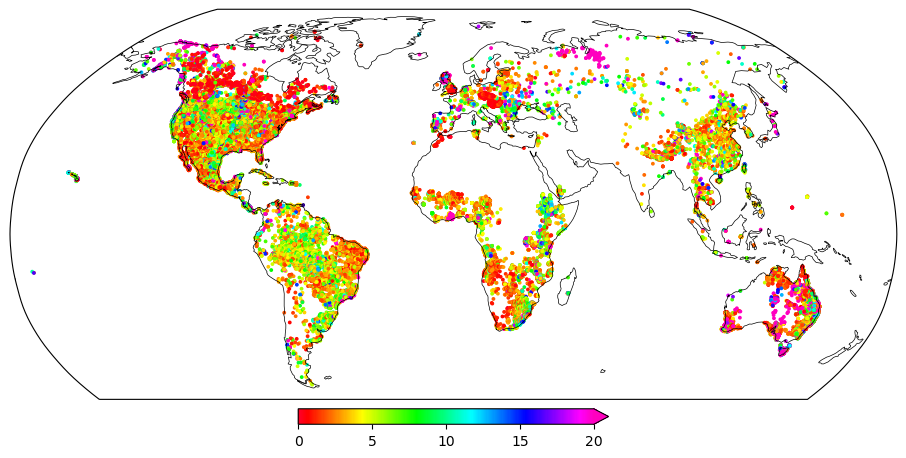

In [99]:
plt.figure(figsize=(10, 5), dpi=100)
# crs = ccrs.PlateCarree(central_longitude=0.0, globe=None)
crs = ccrs.Robinson(central_longitude=0, globe=None)
ax = plt.axes(projection=crs)
ax._autoscaleXon = False
ax._autoscaleYon = False

ax.coastlines(linewidth=0.5)

# cmap = plt.get_cmap('viridis')
cmap = plt.get_cmap('gist_rainbow')
plt_points = ax.scatter(gdf['longitude'], gdf['latitude'], c=gdf['socs'],
                        marker='o', s=3, cmap=cmap, vmin=0, vmax=20,
                        transform=ccrs.PlateCarree())
plt.colorbar(plt_points, cmap=cmap, orientation='horizontal', ticklocation='bottom', spacing='proportional', extend='max', shrink=0.32, pad=0.02)

extent=[-179.999, 179.999, -60, 90]
ax.set_extent(extent, crs=ccrs.PlateCarree())
plt.tight_layout()

plt.savefig('./figure/sample-level_maps/samples_socs_{}.jpg'.format(top_or_sub), bbox_inches='tight', dpi=600)
plt.show()

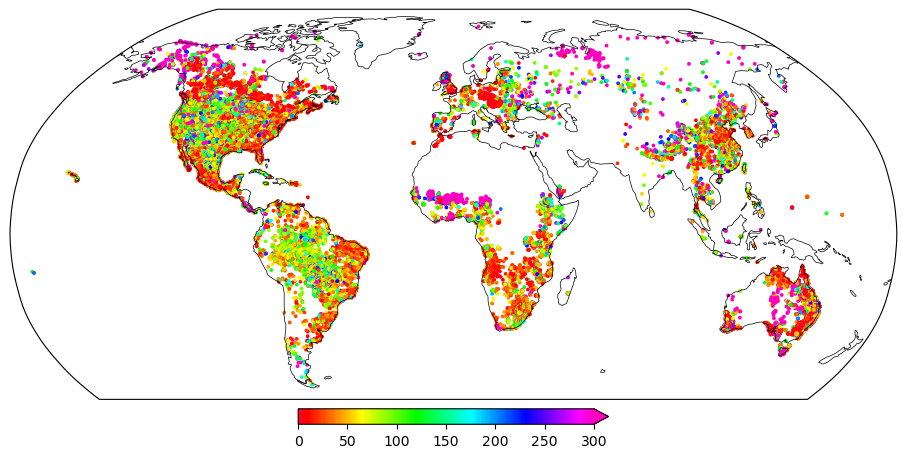

In [100]:
plt.figure(figsize=(10, 5), dpi=100)
# crs = ccrs.PlateCarree(central_longitude=0.0, globe=None)
crs = ccrs.Robinson(central_longitude=0, globe=None)
ax = plt.axes(projection=crs)
ax._autoscaleXon = False
ax._autoscaleYon = False

ax.coastlines(linewidth=0.5)

if top_or_sub == 'topsoil':
    vmax_tovr_apparent = 100
else:
    vmax_tovr_apparent = 300
# cmap = plt.get_cmap('viridis')
cmap = plt.get_cmap('gist_rainbow')
plt_points = ax.scatter(gdf['longitude'], gdf['latitude'], c=gdf['tovr_apparent'],
                        marker='o', s=3, cmap=cmap, vmin=0,
                        vmax=vmax_tovr_apparent,
                        transform=ccrs.PlateCarree())
plt.colorbar(plt_points, cmap=cmap, orientation='horizontal', ticklocation='bottom', spacing='proportional', extend='max', shrink=0.32, pad=0.02)

extent=[-179.999, 179.999, -60, 90]
ax.set_extent(extent, crs=ccrs.PlateCarree())
plt.tight_layout()

plt.savefig('./figure/sample-level_maps/samples_tovr_apparent_{}.jpg'.format(top_or_sub), bbox_inches='tight', dpi=600)
plt.show()

['Tropical forests', 'Temperate forests', 'Boreal forests', 'Tropical savannahs and grasslands', 'Temperate grasslands and shrublands', 'Deserts and xeric shrublands', 'Tundra', 'Croplands', 'Wetlands']


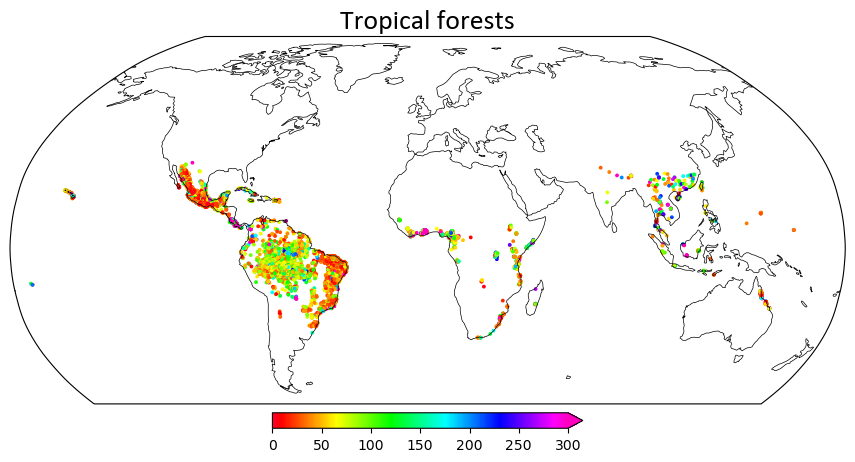

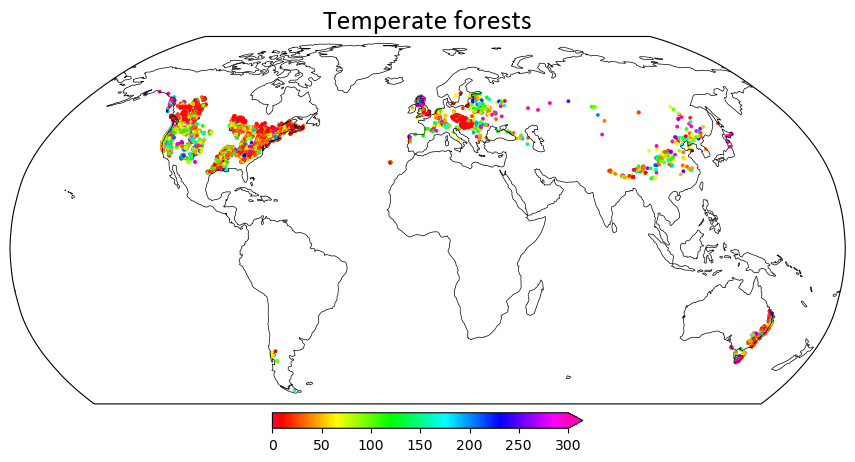

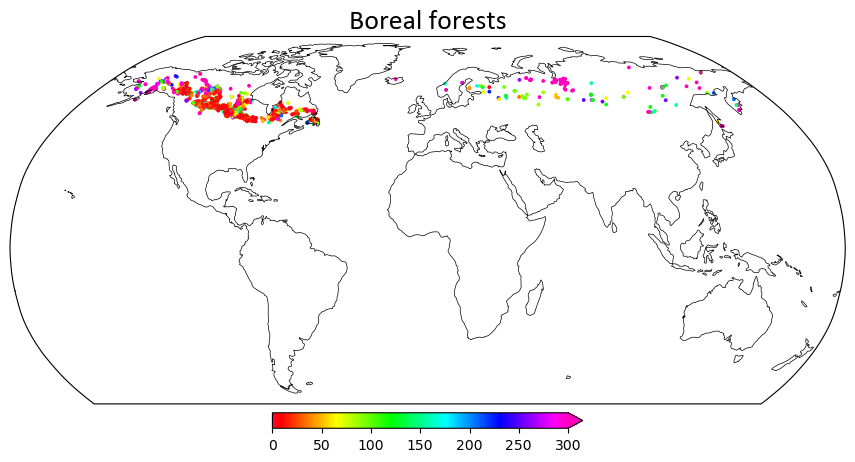

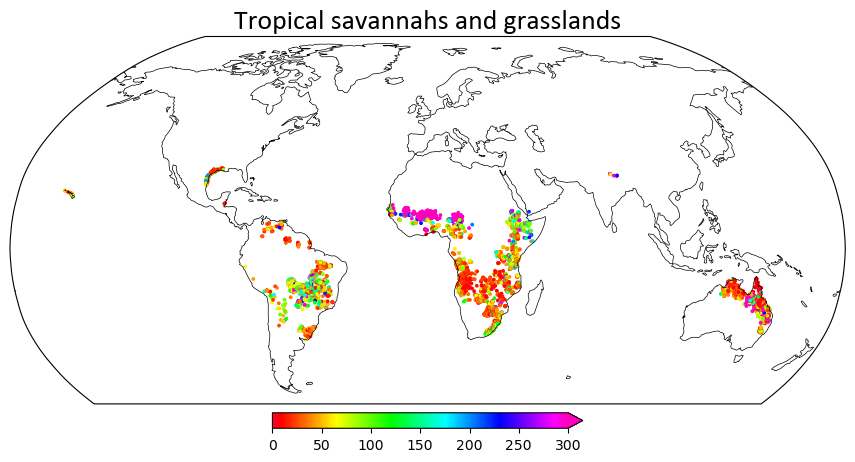

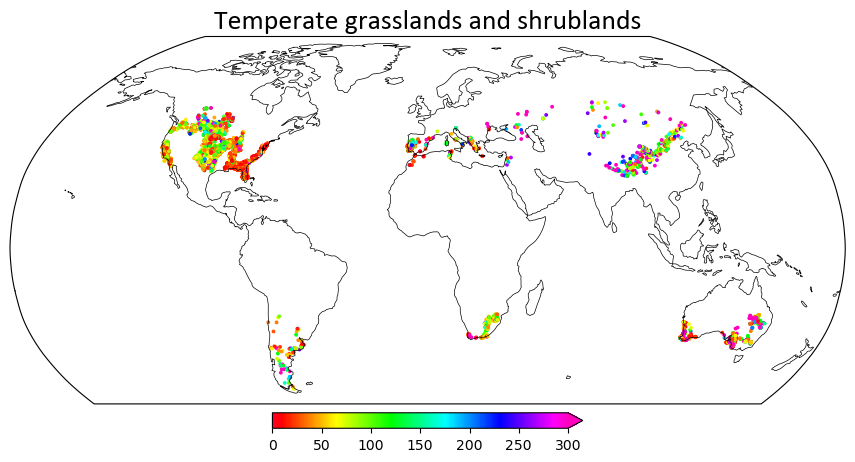

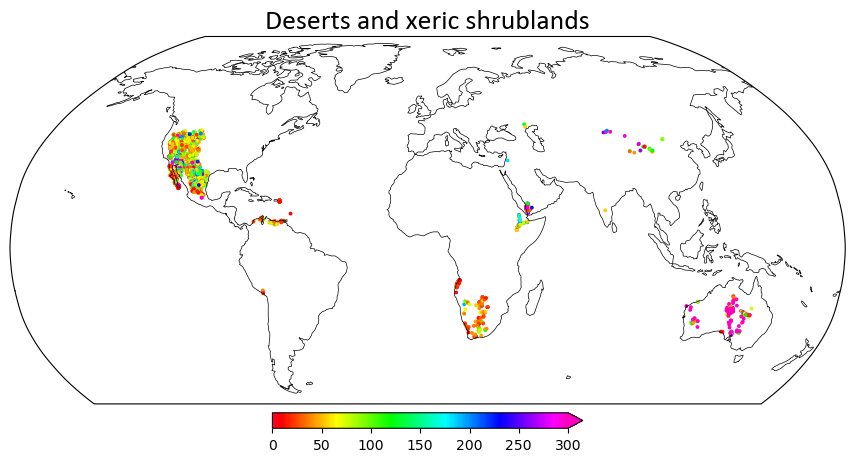

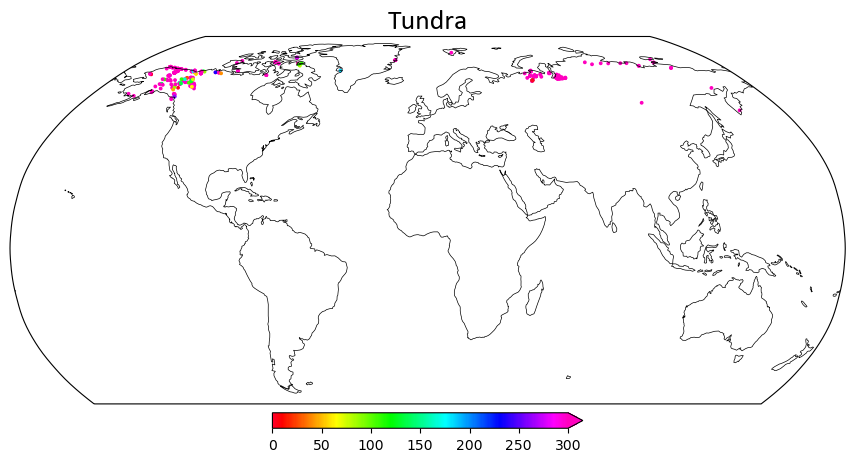

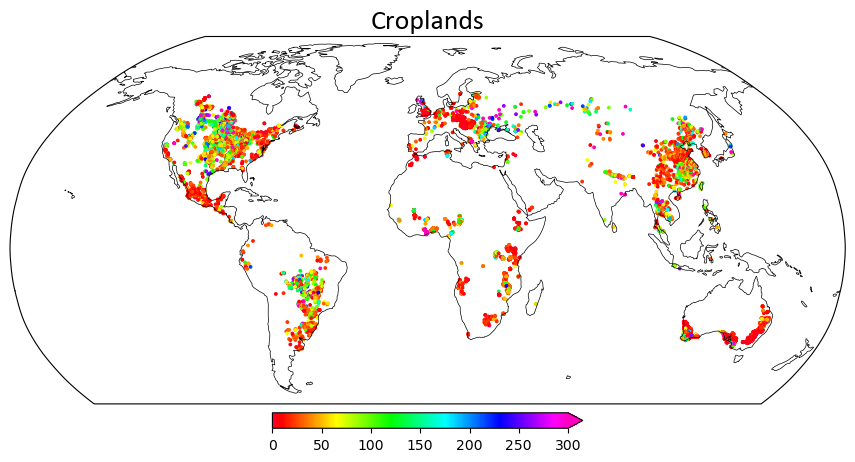

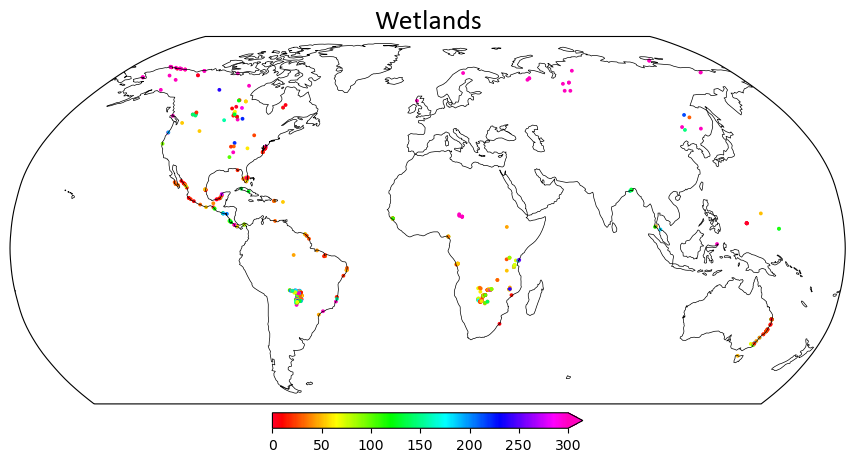

In [104]:
biome_name_list = ['Tropical forests', 'Temperate forests', 'Boreal forests', 'Tropical savannahs and grasslands', 'Temperate grasslands and shrublands', 'Deserts and xeric shrublands', 'Tundra', 'Croplands', 'Wetlands']
print(biome_name_list)

for biome_name in biome_name_list:
    plt.figure(figsize=(10, 5), dpi=100)
    # crs = ccrs.PlateCarree(central_longitude=0.0, globe=None)
    crs = ccrs.Robinson(central_longitude=0, globe=None)
    ax = plt.axes(projection=crs)
    ax._autoscaleXon = False
    ax._autoscaleYon = False
    
    ax.coastlines(linewidth=0.5)
    
    gdf_ = gdf[gdf['biome_type_name'] == biome_name]
    if top_or_sub == 'topsoil':
        vmax_tovr_apparent = 100
    else:
        vmax_tovr_apparent = 300
    # cmap = plt.get_cmap('viridis')
    cmap = plt.get_cmap('gist_rainbow')
    plt_points = ax.scatter(gdf_['longitude'], gdf_['latitude'], c=gdf_['tovr_apparent'],
                            marker='o', s=3, cmap=cmap, vmin=0,
                            vmax=vmax_tovr_apparent,
                            transform=ccrs.PlateCarree())
    plt.colorbar(plt_points, cmap=cmap, orientation='horizontal', ticklocation='bottom', spacing='proportional', extend='max', shrink=0.32, pad=0.02)
    plt.title(biome_name, fontdict={'fontsize': 20, 'family': 'Calibri'})
    
    extent=[-179.999, 179.999, -60, 90]
    ax.set_extent(extent, crs=ccrs.PlateCarree())
    plt.tight_layout()

    plt.savefig('./figure/sample-level_maps/samples_tovr_apparent_{}_{}.jpg'.format(top_or_sub, biome_name), bbox_inches='tight', dpi=600)
    plt.show()

['Non-permafrost', 'Permafrost']


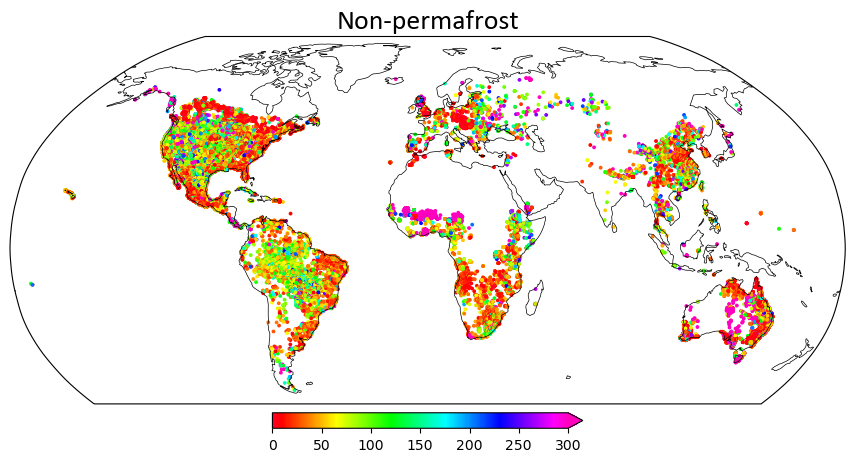

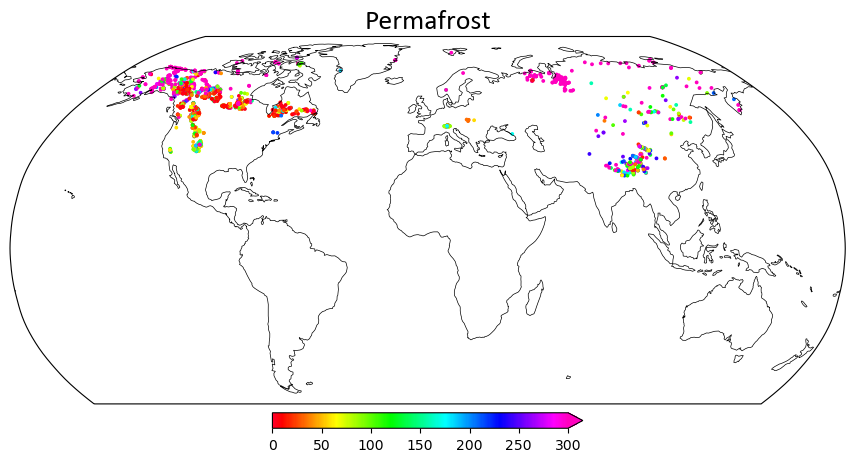

In [111]:
is_permafrost_list = ['Non-permafrost', 'Permafrost']
print(is_permafrost_list)

for is_permafrost in is_permafrost_list:
    plt.figure(figsize=(10, 5), dpi=100)
    # crs = ccrs.PlateCarree(central_longitude=0.0, globe=None)
    crs = ccrs.Robinson(central_longitude=0, globe=None)
    ax = plt.axes(projection=crs)
    ax._autoscaleXon = False
    ax._autoscaleYon = False
    
    ax.coastlines(linewidth=0.5)
    
    gdf_ = gdf[gdf['is_permafrost'] == is_permafrost]
    if top_or_sub == 'topsoil':
        vmax_tovr_apparent = 100
    else:
        vmax_tovr_apparent = 300
    # cmap = plt.get_cmap('viridis')
    cmap = plt.get_cmap('gist_rainbow')
    plt_points = ax.scatter(gdf_['longitude'], gdf_['latitude'], c=gdf_['tovr_apparent'],
                            marker='o', s=3, cmap=cmap, vmin=0,
                            vmax=vmax_tovr_apparent,
                            transform=ccrs.PlateCarree())
    plt.colorbar(plt_points, cmap=cmap, orientation='horizontal', ticklocation='bottom', spacing='proportional', extend='max', shrink=0.32, pad=0.02)
    plt.title(is_permafrost, fontdict={'fontsize': 20, 'family': 'Calibri'})
    
    extent=[-179.999, 179.999, -60, 90]
    ax.set_extent(extent, crs=ccrs.PlateCarree())
    plt.tight_layout()

    plt.savefig('./figure/sample-level_maps/samples_tovr_apparent_{}_{}.jpg'.format(top_or_sub, is_permafrost), bbox_inches='tight', dpi=600)
    plt.show()

In [ ]:
# pd.DataFrame(gdf_valid.drop(columns='geometry')).to_csv('./results/df_samples_topsoil_with_covariates_v6.csv', index=False)

In [102]:
# pd.DataFrame(gdf_valid.drop(columns='geometry')).to_csv('./results/df_samples_subsoil_with_covariates_v6.csv', index=False)